In [1]:
from hera_stats.bias_jackknife import bias_jackknife, bandpower
from hera_pspec import UVPSpec
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import os
from scipy.interpolate import interp1d
from scipy.stats import norm, multivariate_normal, gaussian_kde
from scipy.linalg import block_diag, LinAlgError
import time
from more_itertools import powerset
from itertools import combinations
from matplotlib import cm
from copy import deepcopy

default_hist_kwargs = {"histtype": "step", "bins": "auto", "density": True}

In [ ]:
bp = bandpower()

### Check that we got gaussian draws about the correct mean

In [ ]:
print(f"bandpower mean: {bp.mean}")
print(f"bandpower bias: {bp.bias}")
print(f"bandpower std: {bp.std}")

est_mean = np.mean(bp.bp_draws)
est_std = np.sqrt(np.var(bp.bp_draws))
print(f"bandpower estimated mean: {est_mean}")
print(f"bandpower estimated std: {est_std}")

_, _, _ = plt.hist(bp.bp_draws.flatten(), **default_hist_kwargs)
plt.yscale("log")

### Do a new draw with a bias

In [ ]:
bp = bandpower(bias=1)
print(f"bandpower mean: {bp.mean}")
print(f"bandpower bias: {bp.bias}")
print(f"bandpower std: {bp.std}")

est_mean = np.mean(bp.bp_draws)
est_std = np.sqrt(np.var(bp.bp_draws))
print(f"bandpower estimated mean: {est_mean}")
print(f"bandpower estimated std: {est_std}")

_, _, _ = plt.hist(bp.bp_draws.flatten(), **default_hist_kwargs)
plt.yscale("log")

### Do a draw with a few different scales

In [ ]:
bp = bandpower(bias=1, std=[1, 1.2, 0.8, 1.5])
print(f"bandpower mean: {bp.mean}")
print(f"bandpower bias: {bp.bias}")
print(f"bandpower std: {bp.std}")

est_mean = np.mean(bp.bp_draws)
est_std = np.sqrt(np.var(bp.bp_draws, axis=0))
print(f"bandpower estimated mean: {est_mean}")
print(f"bandpower estimated std: {est_std}")

for ep_ind in range(4):
    _, _, _ = plt.hist(bp.bp_draws[:, ep_ind], **default_hist_kwargs)
plt.yscale("log")

# Make a jackknife object and check numerical vs. analytic posteriors. Check with a histogram

In [ ]:
def hist_check(bias=1, num_draw=int(1e3), std=0.5, check=1, num_pow=2, debug=False, bias_prior_mean=0):
    bp_test = bandpower(bias=bias, num_draw=num_draw, std=std, num_pow=num_pow)
    if check == 1:
        
        title = "Analytic vs. Numerical"
        bjack_1 = bias_jackknife(bp_test, bias_prior_mean=bias_prior_mean, analytic=True)
        bjack_2 = bias_jackknife(bp_test, bias_prior_mean=bias_prior_mean, analytic=False)
    elif check == 2:
        title = "Analytic vs. Analytic"
        bjack_1 = bias_jackknife(bp_test, bias_prior_mean=bias_prior_mean, analytic=True)
        bp_test.std = np.array(num_pow*[std])
        bjack_2 = bias_jackknife(bp_test, bias_prior_mean=bias_prior_mean, analytic=True)
        
        if debug:
            print(f"params for bjack_1 in True case: {bjack_1._get_mod_var_mean_gauss_2(True, debug=True)}")
            print(f"params for bjack_2 in True case: {bjack_2._get_mod_var_mean_gauss_2(True, debug=True)}")
            print(f"params for bjack_1 in False case: {bjack_1._get_mod_var_mean_gauss_2(False, debug=True)}")
            print(f"params for bjack_2 in False case: {bjack_2._get_mod_var_mean_gauss_2(False, debug=True)}")
            return
    else:
        raise ValueError("check keyword can only take values 1 or 2")

    fig, ax = plt.subplots(figsize=(8, 4), ncols=2)
    print(bjack_1.num_hyp)
    
    post_diffs = (bjack_1.post - bjack_2.post)
    frac_post_diffs = post_diffs / (0.5 * (bjack_1.post + bjack_2.post))

    
    _, _, _ = ax[0].hist(post_diffs.flatten(), **default_hist_kwargs)
    _, _, _ = ax[1].hist(frac_post_diffs.flatten(), **default_hist_kwargs)
    ax[0].set_xlabel("Absolute Difference")
    ax[1].set_xlabel("Fractional Difference")
    fig.suptitle(title)

    print(f"max fractional difference is {np.amax(np.abs(frac_post_diffs))}")
    print(f"max absolute difference is {np.amax(np.abs(post_diffs))}")

In [ ]:
hist_check(num_pow=3)

In [ ]:
hist_check(num_pow=3, bias_prior_mean=1)

In [ ]:
hist_check(num_draw=int(1e3), check=2, debug=False)

In [ ]:
hist_check(std=[0.5, 0.5, 0.5, 0.5], check=1, num_pow=4)

In [ ]:
hist_check(std=[0.5, 0.7, 0.1, 0.5], check=1, num_pow=4)

## Do a bigger draw and histogram the posteriors - compare biased vs. unbiased

In [ ]:
bp_big_draw = bandpower(bias=0, num_draw=int(1e7))
bjack_big_draw = bias_jackknife(bp_big_draw, analytic=True)
bp_big_draw_bias = bandpower(bias=1, num_draw=int(1e7))
bjack_big_draw_bias = bias_jackknife(bp_big_draw_bias, analytic=True)



In [ ]:
plt.figure(figsize=(12, 6))
plt.hist(bjack_big_draw.post[0], bins=np.linspace(0, 1, num=1001), histtype='step', density=True, label="Unbiased")
plt.hist(bjack_big_draw_bias.post[0], bins=np.linspace(0, 1, num=1001), histtype='step', density=True, label="Biased")
plt.xlabel("$P(n=0|d)$")
plt.ylabel("PDF")
plt.yscale("log")
plt.xscale("log")
plt.legend()

# Library of useful functions

In [2]:
def make_diag_bpc_list(num_pow, var):
    bpc_list = []
    for epoch_on in powerset(np.arange(num_pow, dtype=int)):
        elems = np.zeros(num_pow)
        elems[np.array(epoch_on, dtype=int)] = var
        bpc_list.append(np.diag(elems))
        
    return(bpc_list)

def make_cov_list(mode, bias_prior_std, num_pow):
    bpc_shape = [num_pow, num_pow]
    var = bias_prior_std**2
    
    if mode == 'ternary':
        bpc_list = [np.zeros(bpc_shape), var * np.eye(num_pow), var * np.ones(bpc_shape)]
    else:
        bpc_list = make_diag_bpc_list(num_pow, var)
        
    return(bpc_list)

def make_sim_from_bpc_list(bpc_list, num_pow, num_draw, mean, std, bias_prior_mean):
    sim_list = []
    for bpc_ind, bpc in enumerate(bpc_list):
        if bpc_ind > 0:
            bpc_diags = np.diag(bpc)
            bias_mean_use = np.where(bpc_diags != 0, bias_prior_mean, 0)
        else:
            bias_mean_use = np.zeros(num_pow)
        bias = np.random.multivariate_normal(mean=bias_mean_use, cov=bpc, size=num_draw)
        sim = bandpower(mean=mean, bias=bias, std=std, num_pow=num_pow, num_draw=num_draw)
        sim_list.append(sim)
    return(sim_list)
        

def make_sim_list(mode, num_pow=3, bp_prior_mean=0.1, bp_prior_std=0.05, std=1, bias_prior_std=10,
                  num_draw=int(1e6), bias_prior_mean=0):
    valid_modes = ['ternary', 'diagonal']
    assert mode in valid_modes, f"mode must be in one of {valid_modes}"
    
    num_draw = int(num_draw)
    
    mean = np.random.normal(loc=bp_prior_mean, scale=bp_prior_std, size=(num_draw, num_pow))
    bpc_list = make_cov_list(mode, bias_prior_std, num_pow)

    sim_list = make_sim_from_bpc_list(bpc_list, num_pow, num_draw, mean, std, bias_prior_mean)
    
    
    return(sim_list)

def get_jk_list(sim_list, mode, num_pow=3, bp_prior_mean=0.1, bp_prior_std=0.05, std=1, bias_prior_std=10,
                num_draw=int(1e6), hyp_prior=None, bias_prior_mean=0):

    jk_list = []
    for sim in sim_list:
        jk = bias_jackknife(sim, bp_prior_mean=bp_prior_mean, bp_prior_std=bp_prior_std,
                            bias_prior_mean=bias_prior_mean,
                            bias_prior_std=bias_prior_std, mode=mode, hyp_prior=hyp_prior)
        
        jk_list.append(jk)
    
    return(jk_list)

            

def get_mut_info(mode, num_pow=3, bp_prior_mean=0.1, bp_prior_std=0.05, std=1, bias_prior_std=10,
                 num_draw=int(1e6), hyp_prior=None, bias_prior_mean=0):
    
    num_draw = int(num_draw)
    sim_list = make_sim_list(mode, num_pow=num_pow, bp_prior_mean=bp_prior_mean, bp_prior_std=bp_prior_std,
                             std=std, bias_prior_std=bias_prior_std, num_draw=num_draw,
                             bias_prior_mean=bias_prior_mean)
    if hyp_prior is None:
        num_hyp = len(sim_list)
        hyp_prior = np.ones(num_hyp) / num_hyp
    
    dat_list = [sim.bp_draws.T for sim in sim_list]
    trial = np.random.multinomial(1, hyp_prior, size=num_draw).argmax(axis=1)
    mixdat = np.choose(trial, dat_list).T
    
    mix_sim = deepcopy(sim_list[0])
    mix_sim.bp_draws = np.copy(mixdat)
    
    jk = bias_jackknife(mix_sim, bp_prior_mean=bp_prior_mean, bp_prior_std=bp_prior_std, mode=mode,
                        bias_prior_std=bias_prior_std, hyp_prior=hyp_prior, bias_prior_mean=bias_prior_mean)
    #jk_list = get_jk_list(sim_list, bp_prior_mean=bp_prior_mean, bp_prior_std=bp_prior_std,
                          #bias_prior_std=bias_prior_std, mode=mode, hyp_prior=hyp_prior,
                          #bias_prior_mean=bias_prior_mean)

    #evid_list = [jk.evid for jk in jk_list]
    
    #evid_samps = np.choose(trial, evid_list)
    #logs = np.where(evid_samps > 0, -np.log2(evid_samps), 0)
    
    #
    #Hcond = jk_list[0].sum_entropy
    
    logs = np.where(jk.evid > 0, -np.log2(jk.evid), 0)
    Hd = logs.mean()
    Hcond = jk.sum_entropy
    
    if np.any(np.isnan(logs)):
        print("Some nans in logs")
        
    if np.any(np.isinf(logs)):
        print("Some infs in logs")
    mut_info = Hd-Hcond
    
    return(mut_info)

def mut_info_wrap(mode, num_pow=4, bp_prior_mean=0, bp_prior_std=0, std=1,
                  bias_prior_means=np.linspace(0, 10, num=100),
                  bias_prior_stds=np.logspace(-3, 3, num=100), num_draw=int(1e6), hyp_prior=None):

    mut_info_arr = np.zeros([len(bias_prior_stds), len(bias_prior_means)])
    for bps_ind, bias_prior_std in enumerate(bias_prior_stds):
        print(bps_ind)
        for bpm_ind, bias_prior_mean in enumerate(bias_prior_means):
            mut_info = get_mut_info(mode, num_pow=num_pow, bp_prior_mean=bp_prior_mean, bp_prior_std=bp_prior_std,
                                    bias_prior_std=bias_prior_std, num_draw=num_draw, std=std, hyp_prior=hyp_prior,
                                    bias_prior_mean=bias_prior_mean)
            mut_info_arr[bps_ind, bpm_ind] = mut_info
    return((bias_prior_stds, bpm, mut_info_arr))


_concs = ["Null hypothesis accepted",
          "All epochs likely biased identically"]
_not_concs = ["Null hypothesis rejectied",
              "All epochs likely biased differently"]

def get_odds(jk, odds_thresh):
    max_post_ind = np.argmax(jk.post)
    odds = jk.post / jk.post[max_post_ind] 
    comp_inds = np.logical_and(odds > 1, odds < odds_thresh).flatten()
    
    conc = {"max_post_ind": max_post_ind, "comp_inds": comp_inds,
            "odds": odds[comp_inds]}
    
    return(odds, conc)

def get_max_compet_combos(epochs, **conc):
    combos = list(powerset(epochs))
    max_post_combo = combos[max_post_ind]
    comp_combos = combos[comp_inds]
    
    return(max_post_combo, comp_combos)
    
    
def run_jk(bp_meas, num_pow=3, bp_prior_mean=0.1, bp_prior_std=0.05, bias_prior_std=10, odds_thresh=10,
           std=1, bias_prior_mean=0, jk_mode="diagonal", print_post=False):
    bp = bandpower(bp_meas=bp_meas, simulate=False, num_pow=num_pow, num_draw=1, std=std)

    modes = ["ternary", "diagonal"]

        
    concs = []
    odds_list = []
    for mode_ind, mode in enumerate(modes):
        if (jk_mode == "diag_only") and (mode != "diagonal"):
            continue
        jk = bias_jackknife(bp, bp_prior_mean=bp_prior_mean, bp_prior_std=bp_prior_std,
                            bias_prior_std=bias_prior_std, mode=mode, bias_prior_mean=bias_prior_mean)
        if print_post:
            print(jk.post)
        odds, conc = get_odds(jk, odds_thresh)
        odds_list.append(odds)
        concs.append(conc)
 
    return(odds_list, concs)
        
    

# Intro plot ("intuition builder")

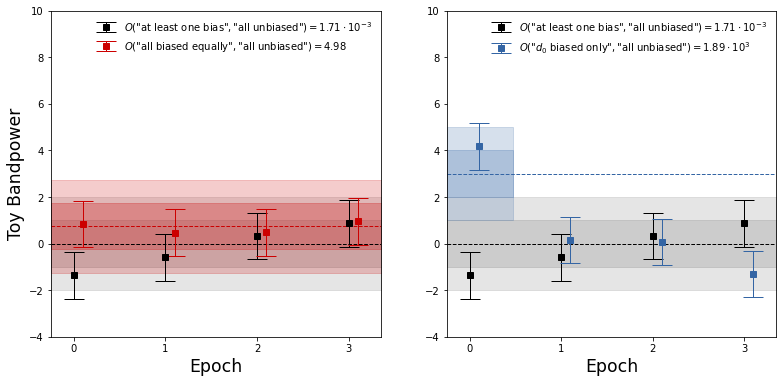

In [ ]:
class int_builder_dat:
    
    def __init__(self, s=0.1, n=1, zwant=4, num_pow=4, new_draw=False, save_new=False,
                 fns=['unbiased_int_build.npy', 'bias1_int_build.npy', 'bias2_int_build.npy'],
                 zcut=0.25):
        self.s = s
        self.n = n
        self.zwant= zwant
        self.num_pow = num_pow
        self.new_draw = new_draw
        self.save_new = save_new
        self.fns = fns
        self.zcut = zcut
        
        self.b1, self.b2 = self.get_b1_b2()
        self.bp_meas_unb, self.bp_meas_b1, self.bp_meas_b2 = self.get_draws()
        
    def get_b1_b2(self):
        b1 = self.zwant / np.sqrt(self.num_pow) * self.n
        b2 = self.zwant * np.sqrt(self.num_pow) * self.n
        return(b1, b2)
    
    def get_draws(self):
        if self.new_draw:
            bp_meas_unb, bp_meas_b1, bp_meas_b2 = self.gen_new_draws()
            bps_meas = [bp_meas_unb, bp_meas_b1, bp_meas_b2]
            if self.save_new:
                for fn, bp_meas in zip(self.fns, bps_meas):
                    np.save(fn, bp_meas)
        else:
            bp_meas_unb, bp_meas_b1, bp_meas_b2 = self.load_draws()
        return(bp_meas_unb, bp_meas_b1, bp_meas_b2)

    def gen_new_draws(self):
        typical=False
        while not typical:
            bp_meas_unb = np.random.normal(loc=self.s, scale=self.n, size=self.num_pow)
            bp_meas_b1 = np.random.normal(loc=self.s + self.b1, scale=self.n, size=self.num_pow)
            bp_meas_b2 = np.random.normal(loc=[self.s + self.b2] + (self.num_pow - 1) * [self.s], scale=self.n,
                                          size=self.num_pow)
            zb1 = np.sqrt(self.num_pow) * np.mean(bp_meas_b1 - self.s) / self.n - self.zwant
            zb2 = np.sqrt(self.num_pow) * np.mean(bp_meas_b2 - self.s) / self.n - self.zwant
            if (np.abs(zb1) < self.zcut) and (np.abs(zb2) < self.zcut):
                typical = True

        return(bp_meas_unb, bp_meas_b1, bp_meas_b2)

    def load_draws(self):
        bps_meas = []
        for fn in self.fns:
            bps_meas.append(np.load(fn))
        bps_meas = tuple(bps_meas)

        return(bps_meas)
    
class int_builder_plot:
    
    def __init__(self, ibd, fn="int_builder.pdf", right_xlim=1.47):
        self.ibd = ibd
        self.set_plot_params(right_xlim)
            
        self.fig, self.ax = fig, ax = plt.subplots(figsize=(13, 6), ncols=2)
        
        
        self.plot_dat()
        self.set_ax_labels()
        self.fig.savefig(fn)
        
    
    def set_plot_params(self, right_xlim):  # Just a bunch of hardocded params I know work well
        self.xunb = np.arange(0, self.ibd.num_pow, dtype=int)
        self.xb = self.xunb + 0.1
        self.ebar_params = {"marker":'s', "yerr":self.ibd.n, "linestyle":'', "capsize":10, "elinewidth":1}
        self.ylim = [-4, 10]
        self.xlim = [-0.25, 3.35]
        self.alpha_high = 0.25
        self.alpha_low = 0.2
        self.colors = ["#cc0000", "#3465a4"]
        self.fill_xlims = [[-0.25, 5], [-0.25, right_xlim]]
    
    def set_ax_labels(self):
        
        
        self.ax[0].set_ylabel("Toy Bandpower", fontsize="xx-large")   
        for ax in self.ax:
            ax.set_ylim(self.ylim)
            ax.set_xlim(self.xlim)
            ax.set_xlabel("Epoch", fontsize="xx-large")
    
    def plot_dat(self):
        legend_entries = [r'$O($"at least one bias"$,$"all unbiased"$) = 1.71\cdot10^{-3}$',
                          r'$O($"all biased equally"$,$"all unbiased"$) = 4.98$',
                          r'$O($"$d_0$ biased only"$,$"all unbiased"$) = 1.89\cdot10^{3}$']
        locs = ["upper left", "center left"]
        for ax_ind, (ax, dat, b) in enumerate(zip(self.ax, [self.ibd.bp_meas_b1, self.ibd.bp_meas_b2],
                                                  [self.ibd.b1, self.ibd.b2])):
            
            ax.errorbar(self.xunb, self.ibd.bp_meas_unb, color='black', label=legend_entries[0], **self.ebar_params)
            ax.axhline(y=self.ibd.s, color='black', linestyle='--', linewidth=1)
            self.do_fill(ax, self.fill_xlims[ax_ind], b, self.colors[ax_ind])
            ax.errorbar(self.xb, dat, color=self.colors[ax_ind], label=legend_entries[1 + ax_ind], **self.ebar_params)
            ax.axhline(y=self.ibd.s + b, color=self.colors[ax_ind], linestyle='--', linewidth=1)
            ax.legend(frameon=False, loc="best")
            ax.set_xticks(range(4))
            
    def do_fill(self, ax_ob, xlims, b, color):
        ax_ob.fill_between([-0.25, 5], self.ibd.s + self.ibd.n, y2 = self.ibd.s-self.ibd.n, color='gray',
                           alpha=self.alpha_high)
        ax_ob.fill_between([-0.25, 5], self.ibd.s + 2 * self.ibd.n, y2 = self.ibd.s-2 * self.ibd.n, color='gray',
                           alpha=self.alpha_low)
        ax_ob.fill_between(xlims, self.ibd.s + b + self.ibd.n, y2 = self.ibd.s + b-self.ibd.n, color=color,
                           alpha=self.alpha_high)
        ax_ob.fill_between(xlims, self.ibd.s + b + 2 * self.ibd.n, y2 = self.ibd.s + b-2 * self.ibd.n, color=color,
                           alpha=self.alpha_low)


ibd = int_builder_dat(zwant=1.5, new_draw=False, save_new=False, zcut=0.5, s=0)
ibp = int_builder_plot(ibd, right_xlim=0.47)

In [45]:
#bp_meas_unb, bp_meas_b1, bp_meas_b2 = ibd.get_draws(new_draw=False, save_new=False, num_pow=4, zcut=0.25, zwant=4)

odds_list = []
conc_list = []
for bp_meas in [ibd.bp_meas_unb, ibd.bp_meas_b1, ibd.bp_meas_b2]:
    odds, conc = run_jk(bp_meas, num_pow=4, bias_prior_std=1, bias_prior_mean=6, print_post=False,
                        bp_prior_mean=0, bp_prior_std=0)
    print(np.sum(odds[1]) - 1)
    print(odds[1])
    print(1 / odds[1][0])

0.00172415850564267
[[1.00000000e+00]
 [2.33689504e-06]
 [1.59913080e-05]
 [2.44875953e-04]
 [1.46056539e-03]
 [3.73700084e-11]
 [5.72249401e-10]
 [3.41318802e-09]
 [3.91588679e-09]
 [2.33563510e-08]
 [3.57657342e-07]
 [9.15101643e-15]
 [5.45813409e-14]
 [8.35807670e-13]
 [5.71940872e-12]
 [1.33656579e-17]]
[1.]
0.004019723864491009
[[1.00000000e+00]
 [1.31471344e-03]
 [3.72250410e-04]
 [3.91155186e-04]
 [1.93642902e-03]
 [4.89402615e-07]
 [5.14256979e-07]
 [2.54584925e-06]
 [1.45607678e-07]
 [7.20836495e-07]
 [7.57444252e-07]
 [1.91432371e-10]
 [9.47693426e-10]
 [9.95822136e-10]
 [2.81958933e-10]
 [3.70695198e-13]]
[1.]
0.0007752589110541219
[[5.30477344e-04]
 [1.00000000e+00]
 [7.24391205e-08]
 [5.59393447e-08]
 [1.39578715e-09]
 [1.36554598e-04]
 [1.05450959e-04]
 [2.63119088e-06]
 [7.63877474e-12]
 [1.90601154e-13]
 [1.47187094e-13]
 [1.43998133e-08]
 [3.59301214e-10]
 [2.77461602e-10]
 [2.00990745e-17]
 [3.78886576e-14]]
[1885.0946437]


## Check which hypotheses are "most discernible" from another and use that as the decision ordering

We have to construct mutual information plots for Stage 1, Stage 2, and potentially Stage 3

In [ ]:
def I2d_plot_wrapper(calc_I=True, save_I=True, num_pow=4, num_draw = int(1e4), save_plot=True,
                     bps = np.logspace(-3, 3, num=100), bpm=np.linspace(0, 10, num=100)):

    prefix = f"mut_info_2d_pow_{num_pow}_draw_{num_draw}"
    npy_fn = f"{prefix}.npy"
    plot_fn = f"{prefix}.pdf"


    if calc_I:
        _, _, I2d = mut_info_wrap("diagonal", num_draw=num_draw, num_pow=num_pow, bias_prior_stds=bps, 
                                      bias_prior_means=bpm)
        if save_I:
            np.save(npy_fn, I2d)
    else:

        I2d = np.load(npy_fn)
    bps_g, bpm_g = np.meshgrid(bps, bpm)
    plt.pcolor(bpm_g, bps_g, I2d.T, cmap='plasma', vmin=0, vmax=4, edgecolors='face')
    plt.colorbar(label="Mutual Information (bits)")
    plt.xlabel("Bias Prior Mean (Error Bar Widths)")
    plt.ylabel("Bias Prior Width (Error Bar Widths)")
    plt.yscale("log")
    if save_plot:
        plt.savefig(plot_fn)
    return(I2d)
I2d = I2d_plot_wrapper(calc_I = False)

In [ ]:
plt.plot(I2d[20, :])
plt.xscale("log")

In [ ]:
modes = ["ternary", "ternary", "diagonal"]
labels = ["Unbiased vs. All Biased Differently", "Unbiased vs. All Biased Identically",
          "All Combinations of Biases"]
hyp_priors = [np.array([0.5, 0.5, 0]), np.array([0.5, 0, 0.5]), None]
num_draw = int(1e6)
fig, ax = plt.subplots(figsize=(8, 4.5))
lines = []
calc_I = False
save=False
num_pow = 4 
bias_prior_mean=0
for mode, label, hyp_prior in zip(modes, labels, hyp_priors):
    if calc_I:
        bps, I = mut_info_wrap(mode, num_draw=num_draw, hyp_prior=hyp_prior, num_pow=num_pow,
                               bias_prior_mean=bias_prior_mean, bias_prior_stds=np.logspace(-2, 2, num=20))
        if save:
            np.save(f"mut_info_demo_{mode}.npy", I)
    else:
        bps = np.logspace(-3, 3, num=100)
        I = np.load(f"mut_info_demo_{mode}.npy")
    if mode == "ternary":
        line, = ax.plot(bps, I, label=label)
        lines.append(line)
    else:
        twin_ax = ax.twinx()
        line, = twin_ax.plot(bps, I, label=label, color="tab:green")
        lines.append(line)
        twin_ax.set_ylabel("Mutual Information (Bits)", fontsize="xx-large")

ax.legend(lines, labels, loc="upper left", frameon=False)
ax.set_ylabel("Mutual Information (Bits)", fontsize="xx-large")
ax.set_xlabel("Bias Prior Width (in Error Bar Units)", fontsize="xx-large")
ax.set_xscale("log")
ax.axvline(10, color='black', linestyle='--')
fig.savefig("mutual_info_demo_3stage.pdf")

In [ ]:
modes = ["diagonal"]
labels = ["All Combinations of Biases"]
hyp_priors = [None]
num_draw = int(1e5)
fig, ax = plt.subplots(figsize=(8, 4.5))
lines = []
calc_I = True
save= True
num_pow = 4 
bias_prior_mean=5
for mode, label, hyp_prior in zip(modes, labels, hyp_priors):
    if calc_I:
        bps, I = mut_info_wrap(mode, num_draw=num_draw, hyp_prior=hyp_prior, num_pow=num_pow,
                               bias_prior_mean=bias_prior_mean, bias_prior_stds=np.logspace(-2, 2, num=20))
        if save:
            np.save(f"mut_info_demo_mean_offset_{mode}.npy", I)
    else:
        bps = np.logspace(-3, 3, num=100)
        I = np.load(f"mut_info_demo_mean_offset_{mode}.npy")
    if mode == "ternary":
        line, = ax.plot(bps, I, label=label)
        lines.append(line)
    else:
        twin_ax = ax.twinx()
        line, = twin_ax.plot(bps, I, label=label, color="tab:green")
        lines.append(line)
        twin_ax.set_ylabel("Mutual Information (Bits)", fontsize="xx-large")

ax.legend(lines, labels, loc="upper left", frameon=False)
ax.set_ylabel("Mutual Information (Bits)", fontsize="xx-large")
ax.set_xlabel("Bias Prior Width (in Error Bar Units)", fontsize="xx-large")
ax.set_xscale("log")
ax.axvline(10, color='black', linestyle='--')
fig.savefig("mutual_info_demo_mean_offset.pdf")

In [ ]:
modes = ["stage1", "stage2", "diagonal"]
labels = ["Stage 1", "Stage 2", "Stage 3"]
num_draw = int(1e4)
fig, ax = plt.subplots(figsize=(8, 4.5))
lines = []
for mode, label in zip(modes, labels):
    bps, I = mut_info_wrap(mode, num_pow=4, num_draw=num_draw, std=[1, 1.2, 1.4, 11])
    if mode in ["stage1", "stage2"]:
        line, = ax.plot(bps, I, label=label)
        lines.append(line)
    else:
        twin_ax = ax.twinx()
        line, = twin_ax.plot(bps, I, label=label, color="tab:green")
        lines.append(line)
        twin_ax.set_ylabel("Mutual Information (Bits)", fontsize="xx-large")

ax.legend(lines, labels, loc="upper left", frameon=False)
ax.set_ylabel("Mutual Information (Bits)", fontsize="xx-large")
ax.set_xlabel("Bias Prior Width (in Error Bar Units)", fontsize="xx-large")
ax.set_xscale("log")
ax.axvline(10, color='black', linestyle='--')

# Toy Section: Low Outliers, Modest Outliers, Strong Outliers
# Distinguishable and indistinguishable choices

How do the classes fill out when you remove hypotheses? (Does a bisection strategy work?)
What is the false positive rate? What is the true positive rate? Plot the ratio.


In [55]:


def get_loss(mode='MAP', loss_val=2):
    L = np.ones([16, 16])
    if mode == 'low_fnr':

        L[0, 1:] = loss_val
    elif mode == 'lin':
        L[0, 1:5] = 2
        L[0, 5:11] = 3
        L[0, 11:15] = 4
        L[0, 15] = 5

        L[1:5, 0] = 2
        L[1:5, 1:5] = 1
        L[1:5, 5:11] = 2
        L[1:5, 11:15] = 3
        L[1:5, 15] = 4

        L[5:11, 0] = 3
        L[5:11, 1:5] = 2
        L[5:11, 5:11] = 1
        L[5:11, 11:15] = 2
        L[5:11, 15] = 3

        L[11:15, 0] = 4
        L[11:15, 1:5] = 3
        L[11:15, 5:11] = 2
        L[11:15, 11:15] = 1
        L[11:15, 15] = 2

        L[15, 0] = 5
        L[15, 1:5] = 4
        L[15, 5:11] = 3
        L[15, 11:15] = 2
        
    elif mode == 'exp':
        L[0, 1:5] = 2
        L[0, 5:11] = 3
        L[0, 11:15] = 4
        L[0, 15] = 5

        L[1:5, 0] = 2
        L[1:5, 1:5] = 1
        L[1:5, 5:11] = 2
        L[1:5, 11:15] = 3
        L[1:5, 15] = 4

        L[5:11, 0] = 3
        L[5:11, 1:5] = 2
        L[5:11, 5:11] = 1
        L[5:11, 11:15] = 2
        L[5:11, 15] = 3

        L[11:15, 0] = 4
        L[11:15, 1:5] = 3
        L[11:15, 5:11] = 2
        L[11:15, 11:15] = 1
        L[11:15, 15] = 2

        L[15, 0] = 5
        L[15, 1:5] = 4
        L[15, 5:11] = 3
        L[15, 11:15] = 2
        
        L = loss_val**(L - 1)
    elif mode == 'time':
        for cind1, combo1 in enumerate(powerset(np.arange(4))):
            for cind2, combo2 in enumerate(powerset(np.arange(4))):
                c1arr = np.array(combo1)
                c2arr = np.array(combo2)
                inarr = np.isin(c1arr, c2arr)
                if not np.any(inarr): # Totally misidentified, have to search every epoch
                    L[cind1, cind2] = 2**4 
                else:
                    L[cind1, cind2] = np.logical_not(inarr).sum()
        L[0, 1:] = loss_val * 2**4
    elif mode == 'fpr_tpr':
        L[0, 1:] = loss_val
        L[1:, 0] = loss_val
    elif mode != "MAP":
        raise ValueError("Valid modes are MAP, low_fnr, exp, and lin")
    L[np.arange(16), np.arange(16)] = 0
    return(L)

def get_perf_matr(bpms=[1, 3, 5], true_means=[1, 3, 5], mode='MAP', loss_val=2, num_draw=int(1e4),
                  bias_prior_std=1e-4):
    L = get_loss(mode=mode, loss_val=loss_val)
    perf_matr = np.zeros([len(bpms), len(true_means), 16, 16])
    for bpm_ind, bpm in enumerate(bpms):
        for tm_ind, true_mean in enumerate(true_means):
            sims = make_sim_list('diagonal', num_pow=4, bp_prior_mean=0, bp_prior_std=0, std=1,
                                 bias_prior_std=bias_prior_std, bias_prior_mean=true_mean, num_draw=num_draw)
            jk_list = get_jk_list(sims, mode="diagonal", num_pow=4, bp_prior_mean=0, bp_prior_std=0, std=1,
                                  bias_prior_mean=bpm, bias_prior_std=bias_prior_std, num_draw=num_draw)
            for jk_ind, jk in enumerate(jk_list):
                #classes = jk.post.argmax(axis=0)
                classes = (L@jk.post).argmin(axis=0)
                perf_matr[bpm_ind, tm_ind, jk_ind] = np.histogram(classes, bins=np.arange(17), density=True)[0]

    return(perf_matr)



[[ 0. 16. 16. 16. 16. 16. 16. 16. 16. 16. 16. 16. 16. 16. 16. 16.]
 [16.  0. 16. 16. 16.  0.  0.  0. 16. 16. 16.  0.  0.  0. 16.  0.]
 [16. 16.  0. 16. 16.  0. 16. 16.  0.  0. 16.  0.  0. 16.  0.  0.]
 [16. 16. 16.  0. 16. 16.  0. 16.  0. 16.  0.  0. 16.  0.  0.  0.]
 [16. 16. 16. 16.  0. 16. 16.  0. 16.  0.  0. 16.  0.  0.  0.  0.]
 [16.  1.  1. 16. 16.  0.  1.  1.  1.  1. 16.  0.  0.  1.  1.  0.]
 [16.  1. 16.  1. 16.  1.  0.  1.  1. 16.  1.  0.  1.  0.  1.  0.]
 [16.  1. 16. 16.  1.  1.  1.  0. 16.  1.  1.  1.  0.  0.  1.  0.]
 [16. 16.  1.  1. 16.  1.  1. 16.  0.  1.  1.  0.  1.  1.  0.  0.]
 [16. 16.  1. 16.  1.  1. 16.  1.  1.  0.  1.  1.  0.  1.  0.  0.]
 [16. 16. 16.  1.  1. 16.  1.  1.  1.  1.  0.  1.  1.  0.  0.  0.]
 [16.  2.  2.  2. 16.  1.  1.  2.  1.  2.  2.  0.  1.  1.  1.  0.]
 [16.  2.  2. 16.  2.  1.  2.  1.  2.  1.  2.  1.  0.  1.  1.  0.]
 [16.  2. 16.  2.  2.  2.  1.  1.  2.  2.  1.  1.  1.  0.  1.  0.]
 [16. 16.  2.  2.  2.  2.  2.  2.  1.  1.  1.  1.  1.  1.  0. 

array([[[[7.100e-03, 1.900e-03, 1.200e-03, ..., 1.471e-01, 1.468e-01,
          1.621e-01],
         [1.200e-03, 1.950e-02, 6.000e-04, ..., 1.676e-01, 3.370e-02,
          9.250e-02],
         [1.800e-03, 4.000e-04, 1.920e-02, ..., 4.100e-02, 1.625e-01,
          8.530e-02],
         ...,
         [1.000e-04, 3.100e-03, 1.000e-04, ..., 2.743e-01, 7.610e-02,
          3.240e-02],
         [0.000e+00, 0.000e+00, 3.900e-03, ..., 7.640e-02, 2.646e-01,
          3.460e-02],
         [0.000e+00, 1.200e-03, 2.400e-03, ..., 1.316e-01, 1.295e-01,
          2.410e-02]],

        [[6.800e-03, 1.900e-03, 2.400e-03, ..., 1.499e-01, 1.423e-01,
          1.567e-01],
         [0.000e+00, 3.337e-01, 0.000e+00, ..., 3.230e-02, 5.000e-04,
          3.300e-03],
         [0.000e+00, 0.000e+00, 3.332e-01, ..., 5.000e-04, 3.350e-02,
          2.500e-03],
         ...,
         [0.000e+00, 4.900e-03, 0.000e+00, ..., 3.070e-02, 1.100e-03,
          0.000e+00],
         [0.000e+00, 0.000e+00, 4.300e-03, ..., 1.

In [183]:
np.save('perf_matr.npy', perf_matr)

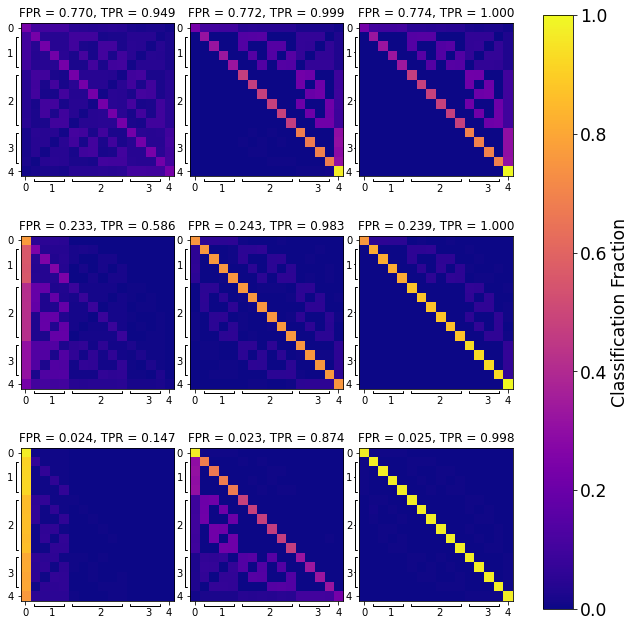

In [57]:
perf_matr = get_perf_matr(mode='low_fnr', loss_val=1)

fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(9, 9))
ann_lowy = 16
ann_lowx = -1
for ax_ind1 in range(3):
    for ax_ind2 in range(3):
        imdat = perf_matr[ax_ind1, ax_ind2]
        ax_ob = ax[ax_ind1, ax_ind2]
        cax = ax_ob.imshow(imdat, vmin=0, vmax=1, cmap='plasma')
        stat_dict = {"FPR": 1 - imdat[0, 0], "TPR": 1-  imdat[1:, 0].mean()}
        stat_dict['ratio'] = stat_dict['TPR'] / stat_dict['FPR']
        ax_ob.set_title("FPR = %.3f, TPR = %.3f" % (stat_dict['FPR'], stat_dict['TPR']))
        ax_ob.annotate('1', xy=(ann_lowx, 2.5), xytext=(-1.9, 3), arrowprops=dict(arrowstyle='-[, widthB=1.5, lengthB=0.2',
                                                                              connectionstyle='angle'),
                      annotation_clip=False)
        ax_ob.annotate('2', xy=(ann_lowx, 7.5), xytext=(-1.9, 8), arrowprops=dict(arrowstyle='-[, widthB=2.5, lengthB=0.2',
                                                                              connectionstyle='angle'),
                      annotation_clip=False)
        ax_ob.annotate('3', xy=(ann_lowx, 12.5), xytext=(-1.9, 13), arrowprops=dict(arrowstyle='-[, widthB=1.5, lengthB=0.2',
                                                                              connectionstyle='angle'),
                      annotation_clip=False)
        ax_ob.annotate('1', xy=(2.5, ann_lowy), xytext=(2.5, 17.1),
                       arrowprops=dict(arrowstyle='-[, widthB=1.5, lengthB=0.2, angleB=-90',
                       connectionstyle='angle'),
                      annotation_clip=False)
        ax_ob.annotate('2', xy=(7.5, ann_lowy), xytext=(7.5, 17.1),
                       arrowprops=dict(arrowstyle='-[, widthB=2.5, lengthB=0.2, angleB=-90',
                       connectionstyle='angle'),
                      annotation_clip=False)
        ax_ob.annotate('3', xy=(12.5, ann_lowy), xytext=(12.5, 17.1),
                       arrowprops=dict(arrowstyle='-[, widthB=1.5, lengthB=0.2, angleB=-90',
                       connectionstyle='angle'),
                      annotation_clip=False)
        ax_ob.set_xticks([0, 15])
        ax_ob.set_xticklabels([0, 4])
        ax_ob.set_yticks([0, 15])
        ax_ob.set_yticklabels([0, 4])
fig.tight_layout()
cbar = fig.colorbar(cm.ScalarMappable(norm=mpl.colors.Normalize(vmin=0, vmax=1), cmap='plasma'), ax=ax)
cbar.set_label("Classification Fraction", fontsize='xx-large')
cbar.ax.tick_params(labelsize='xx-large')
fig.savefig("toy_class.pdf")


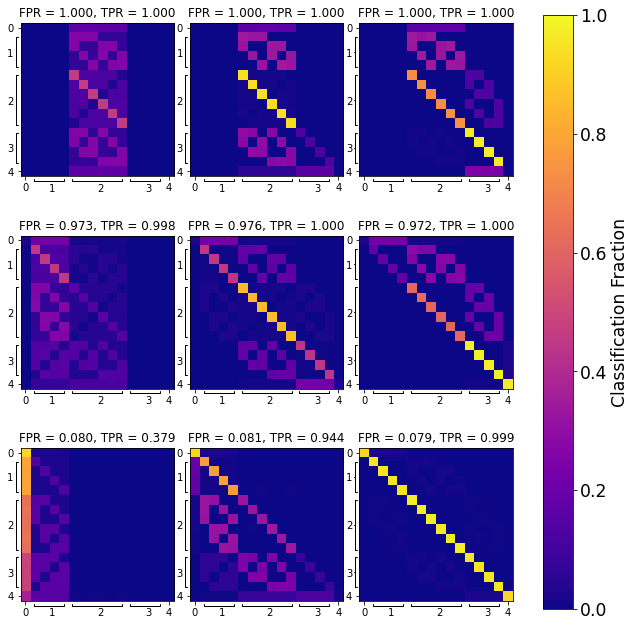

In [119]:
perf_matr = get_perf_matr(mode='exp', loss_val=1e4)

fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(9, 9))
ann_lowy = 16
ann_lowx = -1
for ax_ind1 in range(3):
    for ax_ind2 in range(3):
        imdat = perf_matr[ax_ind1, ax_ind2]
        ax_ob = ax[ax_ind1, ax_ind2]
        cax = ax_ob.imshow(imdat, vmin=0, vmax=1, cmap='plasma')
        stat_dict = {"FPR": 1 - imdat[0, 0], "TPR": 1-  imdat[1:, 0].mean()}
        stat_dict['ratio'] = stat_dict['TPR'] / stat_dict['FPR']
        ax_ob.set_title("FPR = %.3f, TPR = %.3f" % (stat_dict['FPR'], stat_dict['TPR']))
        ax_ob.annotate('1', xy=(ann_lowx, 2.5), xytext=(-1.9, 3), arrowprops=dict(arrowstyle='-[, widthB=1.5, lengthB=0.2',
                                                                              connectionstyle='angle'),
                      annotation_clip=False)
        ax_ob.annotate('2', xy=(ann_lowx, 7.5), xytext=(-1.9, 8), arrowprops=dict(arrowstyle='-[, widthB=2.5, lengthB=0.2',
                                                                              connectionstyle='angle'),
                      annotation_clip=False)
        ax_ob.annotate('3', xy=(ann_lowx, 12.5), xytext=(-1.9, 13), arrowprops=dict(arrowstyle='-[, widthB=1.5, lengthB=0.2',
                                                                              connectionstyle='angle'),
                      annotation_clip=False)
        ax_ob.annotate('1', xy=(2.5, ann_lowy), xytext=(2.5, 17.1),
                       arrowprops=dict(arrowstyle='-[, widthB=1.5, lengthB=0.2, angleB=-90',
                       connectionstyle='angle'),
                      annotation_clip=False)
        ax_ob.annotate('2', xy=(7.5, ann_lowy), xytext=(7.5, 17.1),
                       arrowprops=dict(arrowstyle='-[, widthB=2.5, lengthB=0.2, angleB=-90',
                       connectionstyle='angle'),
                      annotation_clip=False)
        ax_ob.annotate('3', xy=(12.5, ann_lowy), xytext=(12.5, 17.1),
                       arrowprops=dict(arrowstyle='-[, widthB=1.5, lengthB=0.2, angleB=-90',
                       connectionstyle='angle'),
                      annotation_clip=False)
        ax_ob.set_xticks([0, 15])
        ax_ob.set_xticklabels([0, 4])
        ax_ob.set_yticks([0, 15])
        ax_ob.set_yticklabels([0, 4])
fig.tight_layout()
cbar = fig.colorbar(cm.ScalarMappable(norm=mpl.colors.Normalize(vmin=0, vmax=1), cmap='plasma'), ax=ax)
cbar.set_label("Classification Fraction", fontsize='xx-large')
cbar.ax.tick_params(labelsize='xx-large')
fig.savefig("toy_class_exp.pdf")



# Modulate the loss function and calculate the TPR and FPR as a function of loss level and bias strength

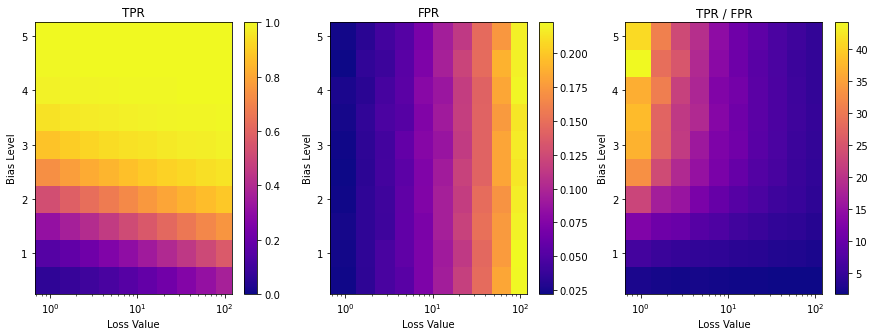

In [51]:
def get_TPR_FPR(num_loss=10, num_means=10, loss_max=2, mean_max=5, mode="low_fnr"):

    
    
    FPR = np.zeros([num_loss, num_means])
    TPR = np.zeros([num_loss, num_means])

    losses=np.logspace(0, loss_max, num=num_loss)
    true_means = np.linspace(0.5, mean_max, num=num_means)

    for loss_ind, loss_val in enumerate(losses):
        perf_matr = get_perf_matr(bpms=[5, ], true_means=true_means, mode=mode,
                                  loss_val=loss_val)
        for tm_ind in range(num_means):
            FPR[loss_ind, tm_ind] = 1 - perf_matr[0, tm_ind, 0, 0]
            TPR[loss_ind, tm_ind] = 1 - perf_matr[0, tm_ind, 1:, 0].mean()
    return(losses, true_means, TPR, FPR)

def plot_TPR_FPR(losses, true_means, TPR, FPR):
    xg, yg = np.meshgrid(losses, true_means, indexing='xy')
    fig, ax = plt.subplots(ncols=3, figsize=(15, 5))
    cax0 = ax[0].pcolor(xg, yg, TPR.T, vmin=0, vmax=1, cmap="plasma")
    ax[0].set_title("TPR")
    fig.colorbar(cax0, ax=ax[0])
    cax1 = ax[1].pcolor(xg, yg, FPR.T, cmap="plasma")
    fig.colorbar(cax1, ax=ax[1])
    ax[1].set_title("FPR")
    cax2 = ax[2].pcolor(xg, yg, TPR.T / FPR.T, cmap="plasma")
    fig.colorbar(cax2, ax=ax[2])
    ax[2].set_title("TPR / FPR")
    for ax_ob in ax:

        ax_ob.set_xlabel("Loss Value")
        ax_ob.set_ylabel("Bias Level")
        ax_ob.set_xscale("log")
        
losses, true_means, TPR, FPR = get_TPR_FPR()
plot_TPR_FPR(losses, true_means, TPR, FPR)

[[0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]]
[[ 0.          2.7825594   2.7825594   2.7825594   2.7825594   7.74263683
   7.74263683  7.74263683  7.74263683  7.74263683  7.74263683 21.5443469
  21.5443469  21.5443469  21.5443469

[[0.00000000e+00 5.99484250e+01 5.99484250e+01 5.99484250e+01
  5.99484250e+01 3.59381366e+03 3.59381366e+03 3.59381366e+03
  3.59381366e+03 3.59381366e+03 3.59381366e+03 2.15443469e+05
  2.15443469e+05 2.15443469e+05 2.15443469e+05 1.29154967e+07]
 [5.99484250e+01 0.00000000e+00 1.00000000e+00 1.00000000e+00
  1.00000000e+00 5.99484250e+01 5.99484250e+01 5.99484250e+01
  5.99484250e+01 5.99484250e+01 5.99484250e+01 3.59381366e+03
  3.59381366e+03 3.59381366e+03 3.59381366e+03 2.15443469e+05]
 [5.99484250e+01 1.00000000e+00 0.00000000e+00 1.00000000e+00
  1.00000000e+00 5.99484250e+01 5.99484250e+01 5.99484250e+01
  5.99484250e+01 5.99484250e+01 5.99484250e+01 3.59381366e+03
  3.59381366e+03 3.59381366e+03 3.59381366e+03 2.15443469e+05]
 [5.99484250e+01 1.00000000e+00 1.00000000e+00 0.00000000e+00
  1.00000000e+00 5.99484250e+01 5.99484250e+01 5.99484250e+01
  5.99484250e+01 5.99484250e+01 5.99484250e+01 3.59381366e+03
  3.59381366e+03 3.59381366e+03 3.59381366e+03 2.15443469e+05]
 [5.

[[0.00000000e+00 1.29154967e+03 1.29154967e+03 1.29154967e+03
  1.29154967e+03 1.66810054e+06 1.66810054e+06 1.66810054e+06
  1.66810054e+06 1.66810054e+06 1.66810054e+06 2.15443469e+09
  2.15443469e+09 2.15443469e+09 2.15443469e+09 2.78255940e+12]
 [1.29154967e+03 0.00000000e+00 1.00000000e+00 1.00000000e+00
  1.00000000e+00 1.29154967e+03 1.29154967e+03 1.29154967e+03
  1.29154967e+03 1.29154967e+03 1.29154967e+03 1.66810054e+06
  1.66810054e+06 1.66810054e+06 1.66810054e+06 2.15443469e+09]
 [1.29154967e+03 1.00000000e+00 0.00000000e+00 1.00000000e+00
  1.00000000e+00 1.29154967e+03 1.29154967e+03 1.29154967e+03
  1.29154967e+03 1.29154967e+03 1.29154967e+03 1.66810054e+06
  1.66810054e+06 1.66810054e+06 1.66810054e+06 2.15443469e+09]
 [1.29154967e+03 1.00000000e+00 1.00000000e+00 0.00000000e+00
  1.00000000e+00 1.29154967e+03 1.29154967e+03 1.29154967e+03
  1.29154967e+03 1.29154967e+03 1.29154967e+03 1.66810054e+06
  1.66810054e+06 1.66810054e+06 1.66810054e+06 2.15443469e+09]
 [1.

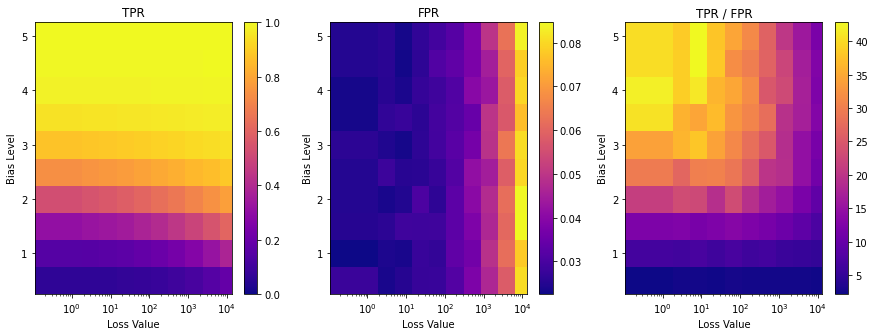

In [116]:
losses, true_means, TPR, FPR = get_TPR_FPR(mode='exp', loss_max=4)
plot_TPR_FPR(losses, true_means, TPR, FPR)

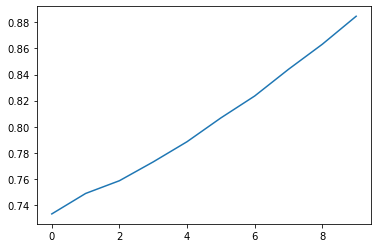

In [120]:
plt.plot(TPR.T[4, :])

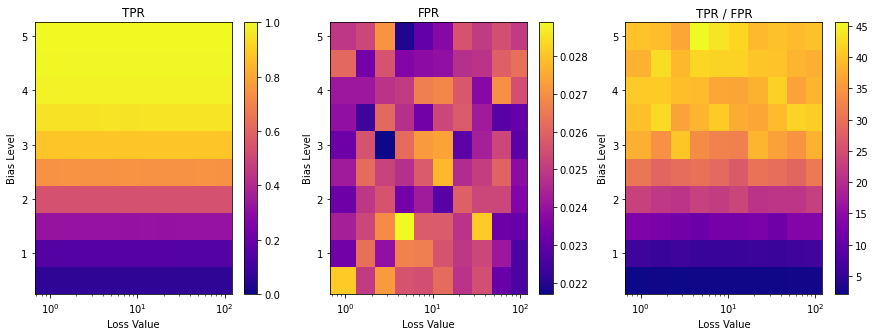

In [107]:
losses, true_means, TPR, FPR = get_TPR_FPR(mode='lin')
plot_TPR_FPR(losses, true_means, TPR, FPR)

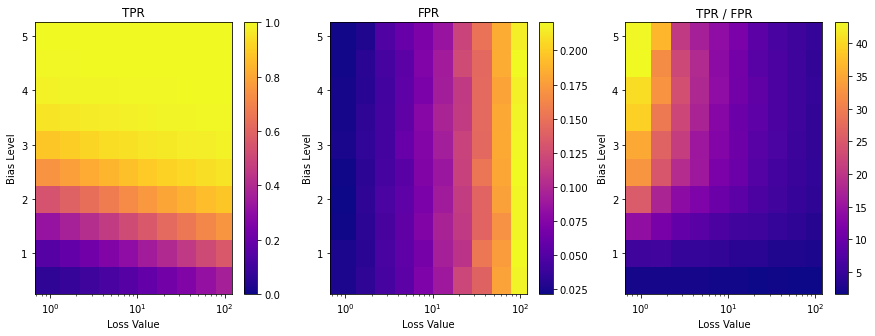

In [56]:
losses, true_means, TPR, FPR = get_TPR_FPR(mode='time')
plot_TPR_FPR(losses, true_means, TPR, FPR)

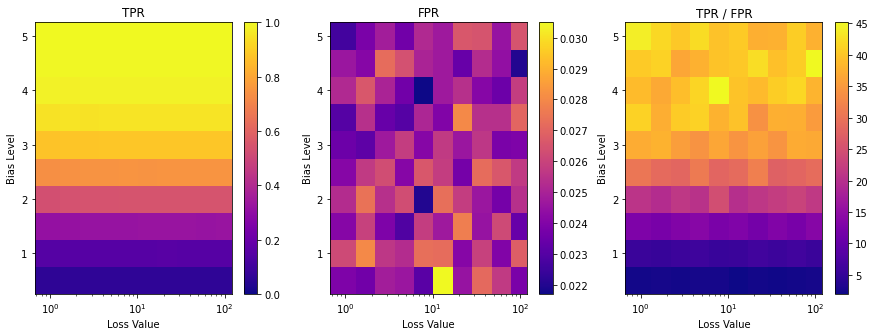

In [54]:
losses, true_means, TPR, FPR = get_TPR_FPR(mode='fpr_tpr')
plot_TPR_FPR(losses, true_means, TPR, FPR)

/var/folders/sh/jrl43dfn78z4f330dx65kh9m0000gn/T/ipykernel_49556/2410256907.py:3: UserWarning: The following kwargs were not used by contour: 'color'
  plt.contour(xg, yg, 15 * TPR.T / FPR.T, color='black', levels=np.arange(0, 700, 100))


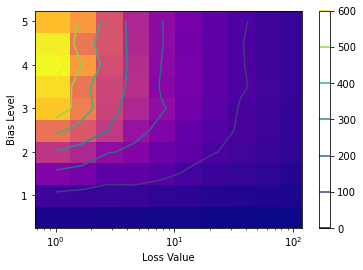

In [84]:
xg, yg = np.meshgrid(losses, true_means)
plt.pcolor(xg, yg, 15 * TPR.T / FPR.T, cmap="plasma")
plt.contour(xg, yg, 15 * TPR.T / FPR.T, levels=np.arange(0, 700, 100))
plt.xlabel("Loss Value")
plt.ylabel("Bias Level")
plt.xscale("log")
plt.colorbar()

{'bodies': [<matplotlib.collections.PolyCollection at 0x15aa487c0>,
  <matplotlib.collections.PolyCollection at 0x15aa496c0>]}

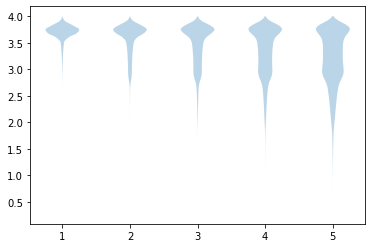

In [199]:
Hs = []
ind_use = [0, 1, 5, 11, 15]
for jk_ind, jk in enumerate(jk_list):
    if jk_ind in ind_use:
        logs = np.where(jk.post > 0, np.log2(jk.post), 0)
        H = -np.sum(jk.post * logs, axis=0)
        Hs.append(H)

#_, _, _ = plt.hist(np.array(Hs).T, bins="auto", histtype='step', log=True)
plt.violinplot(Hs, showextrema=False)

true_std = 2
sims = make_sim_list('diagonal', num_pow=4, bp_prior_mean=0.1, bp_prior_std=0.05, std=1, bias_prior_std=true_std,
                     num_draw=int(1e4))

jk_list = get_jk_list(sims, mode="diagonal", num_pow=4, bp_prior_mean=0.1, bp_prior_std=0.05, std=1,
                                  bias_prior_std=70, num_draw=int(1e4))
def sens_fpr_sig(jk_list, sig=3):

    true_pos_total = 0
    is_pos_total = 0
    false_pos_total = 0
    is_neg_total = 0
    for jk in jk_list:
        where_is_pos = (np.any(np.abs(jk.bp_obj.bias) > sig, axis=1))
        where_not_pos = np.logical_not(where_is_pos)
        where_class_pos = (np.argmax(jk.post, axis=0) > 0)
        
        num_is_pos = where_is_pos.sum()


        num_not_pos = where_not_pos.sum()
        
        where_true_pos = np.logical_and(where_class_pos, where_is_pos)
        where_false_pos = np.logical_and(where_class_pos, where_not_pos)
        
        num_true_pos = where_true_pos.sum()
        num_false_pos = where_false_pos.sum()
        

        true_pos_total += num_true_pos
        is_pos_total += num_is_pos
        false_pos_total += num_false_pos
        is_neg_total += num_not_pos

    sens = true_pos_total / is_pos_total
    fpr = false_pos_total / is_neg_total
    return(sens, fpr)

sens, fpr = sens_fpr_sig(jk_list, sig=6)
print(sens, fpr)

In [ ]:
def sens_fpr_ratio_wrapper(bias_prior_stds=np.arange(1, 101), true_std=1, num_draw=int(1e4), sig=3):
    sens_fpr_rats = []
    for bias_prior_std in bias_prior_stds:
        sims = make_sim_list('diagonal', num_pow=4, bp_prior_mean=0.1, bp_prior_std=0.05, std=1, bias_prior_std=true_std,
                             num_draw=num_draw)

        jk_list = get_jk_list(sims, mode="diagonal", num_pow=4, bp_prior_mean=0.1, bp_prior_std=0.05, std=1,
                              bias_prior_std=bias_prior_std, num_draw=num_draw)
        sens, fpr = sens_fpr_sig(jk_list, sig=sig)
        print(sens, fpr)
        sens_fpr_rats.append(sens / fpr)
    return(np.array(sens_fpr_rats))

bias_prior_stds = np.arange(10, 110, 10)
for true_std in range(1, 6):
    rats = sens_fpr_ratio_wrapper(bias_prior_stds=bias_prior_stds, true_std=true_std, num_draw=int(1e4), sig=3)
    plt.plot(bias_prior_stds, rats)
    plt.axhline(10, color='black', linestyle='--')

In [ ]:
def hist_odds(jk_list, norm_ind, label, bins=np.logspace(-7, 3, num=101)):
    odds = jk_list[norm_ind].post / jk_list[norm_ind].post[norm_ind]
    if norm_ind == 0:
        #spec = (np.argmax(odds, axis=0) == 0).mean()
        spec = (np.amax(odds[1:], axis=0) < 1).mean()
        print(f"{label} specificity: {spec}")
    plt.hist(odds.flatten(), bins=bins, histtype='step', label=label)
    plt.xscale("log")
    plt.legend()
    
def hist_odds_wrapper(good_jk_list, bad_jk_list, norm_ind):
    jk_lists = [good_jk_list, bad_jk_list]
    labels = ["correct prior", "incorrect prior"]
    for jk_list, label in zip(jk_lists, labels):
        hist_odds(jk_list, norm_ind, label)
        

hist_odds_wrapper(jk_list_good_prior, jk_list_bad_prior, 0)

### Intuition-building Plot

In [ ]:
def get_lods(p1, p2):
    return(10 * np.log10(p1 / p2)[30])

num_pow = 4

X = np.linspace(0, 10, num=100)
Y = np.zeros([100, num_pow])
Y[:, 0] = X

lods10 = []
lods12 = []
lods31 = []
stds = np.logspace(0, 2, num=100, base=10)
for std in stds:
    var = std**2
    p0 = multivariate_normal.pdf(Y, mean=np.zeros(num_pow), cov=np.eye(num_pow))
    
    
    p1 = multivariate_normal.pdf(Y, mean=np.zeros(num_pow), cov=np.eye(num_pow)*(var + 1))
    p2 = multivariate_normal.pdf(Y, mean=np.zeros(num_pow), cov=np.eye(num_pow) + var * np.ones([num_pow, num_pow]))
    p3 = multivariate_normal.pdf(Y, mean=np.zeros(num_pow),
                                 cov=var * np.diag([1] + (num_pow - 1) * [0]) + np.eye(num_pow))
    
    lods10.append(get_lods(p3, p0))
    lods12.append(get_lods(p3, p2))
    lods31.append(get_lods(p3, p1))

    
plt.plot(stds, lods10, label="3/0")
plt.plot(stds, lods12, label="3/2")
plt.plot(stds, lods31, label="3/1")
plt.axhline(0, color='black', linestyle='--')
plt.legend()
print(stds[np.argmax(np.array(lods31) + np.array(lods12) + np.array(lods10))])

# Make a plot of the mutual information as a function of bias std and corrrelation coefficient.

In [ ]:

def get_H(p):
    return(-np.sum(p * np.log2(p), axis=0))




    


# Memo sampling distribution plot

# Beware all ye blinded folks! Spherical bandpowers be shown below!
# Beware all ye blinded folks! Spherical bandpowers be shown below!
# Beware all ye blinded folks! Spherical bandpowers be shown below!
# Beware all ye blinded folks! Spherical bandpowers be shown below!
# Beware all ye blinded folks! Spherical bandpowers be shown below!
# Beware all ye blinded folks! Spherical bandpowers be shown below!
# Beware all ye blinded folks! Spherical bandpowers be shown below!
# Beware all ye blinded folks! Spherical bandpowers be shown below!
# Beware all ye blinded folks! Spherical bandpowers be shown below!
# Beware all ye blinded folks! Spherical bandpowers be shown below!
# Beware all ye blinded folks! Spherical bandpowers be shown below!
# Beware all ye blinded folks! Spherical bandpowers be shown below!
# Beware all ye blinded folks! Spherical bandpowers be shown below!
# Beware all ye blinded folks! Spherical bandpowers be shown below!
# Beware all ye blinded folks! Spherical bandpowers be shown below!

In [3]:
ps_repo = "/Users/mike_e_dubs/Repositories/H1C_IDR3_Power_Spectra"
epoch_0_results = f"{ps_repo}/Epoch_0_Power_Spectra/results_files"
epoch_res_dirs = [epoch_0_results, ]
for epoch in range(1, 4):
    epoch_results = f"{ps_repo}/SPOILERS/Epoch_{epoch}_Power_Spectra/results_files"
    
    epoch_res_dirs.append(epoch_results)
print(epoch_res_dirs)

['/Users/mike_e_dubs/Repositories/H1C_IDR3_Power_Spectra/Epoch_0_Power_Spectra/results_files', '/Users/mike_e_dubs/Repositories/H1C_IDR3_Power_Spectra/SPOILERS/Epoch_1_Power_Spectra/results_files', '/Users/mike_e_dubs/Repositories/H1C_IDR3_Power_Spectra/SPOILERS/Epoch_2_Power_Spectra/results_files', '/Users/mike_e_dubs/Repositories/H1C_IDR3_Power_Spectra/SPOILERS/Epoch_3_Power_Spectra/results_files']


In [4]:
def get_epochs_in_band_field(band, field):
    epoch_list = []
    for epoch, epoch_res_dir in enumerate(epoch_res_dirs):
        if os.path.exists(f"{epoch_res_dir}/Pofk_Band_{band}_Field_{field}.h5"):
            epoch_list.append(epoch)
    return(epoch_list)

bands = list('12')
fields = list('ABCDE')

epoch_dict = {}
for band in bands:
    for field in fields:
        band_field_key = (band, field)
        epoch_dict[band_field_key] = get_epochs_in_band_field(band, field)
print(epoch_dict)
epoch_dict[('1', 'C')] = [0, 1, 2]
epoch_dict[('2', 'C')] = [0, 1, 2]
print(epoch_dict)

{('1', 'A'): [0], ('1', 'B'): [0, 1], ('1', 'C'): [0, 1, 2, 3], ('1', 'D'): [0, 1, 2, 3], ('1', 'E'): [1, 2, 3], ('2', 'A'): [0], ('2', 'B'): [0, 1], ('2', 'C'): [0, 1, 2, 3], ('2', 'D'): [0, 1, 2, 3], ('2', 'E'): [1, 2, 3]}
{('1', 'A'): [0], ('1', 'B'): [0, 1], ('1', 'C'): [0, 1, 2], ('1', 'D'): [0, 1, 2, 3], ('1', 'E'): [1, 2, 3], ('2', 'A'): [0], ('2', 'B'): [0, 1], ('2', 'C'): [0, 1, 2], ('2', 'D'): [0, 1, 2, 3], ('2', 'E'): [1, 2, 3]}


In [5]:
#spw = 0
#field = "B"
#bp_prior_mean = 300
#bp_prior_std = bp_prior_mean / 2
#bias_prior_std = 1e5

def get_uvp_goodies(spw, field, mode, epochs=np.arange(4, dtype=int), comp='real'):
    bp_meas = []
    stds = []
    if mode == 'dsq':
        modestr = "Deltasq"
    elif mode == 'pk':
        modestr = 'Pofk'
    else:
        raise ValueError("mode must be 'dsq' or 'pk'")
    for epoch in epochs:
        uvp = UVPSpec()
        path = f"{epoch_res_dirs[epoch]}/{modestr}_Band_{spw}_Field_{field}.h5"
        if os.path.exists(path):
            uvp.read_hdf5(path)
            bp_meas.append(getattr(uvp.data_array[0].squeeze(), comp))
            stds.append(np.sqrt(uvp.cov_array_real[0].squeeze().diagonal()))
        else:
            print(f"Could not find results file for epoch {epoch}, Band {spw}, Field {field}")
            continue

    if spw == 1:
        num_k = 29      
    else:
        num_k = 25
    
    # First 3 are all 0, only the next num_k are reported in this band
    bp_meas_k = np.array(bp_meas)[:, 3:3 + num_k]
    stds_k = np.array(stds)[:, 3:3 + num_k]
    ks = uvp.get_kparas(0)[3:3 + num_k] # The kparas store the actual k magnitude in these files?
    
    return(bp_meas_k, stds_k, ks)



In [92]:
def get_odds_list_k(ks, stds_k, bp_meas_k, epochs, bppm=10, use_I=False, bias_prior_std=1, jk_mode="diag_only",
                    bias_prior_mean=6, mult=True):
    odds_list_k = []
    conc_list_k = []
    for k_ind, k in enumerate(ks):
        bppm_use = bppm * 2 * np.pi**2 / k**3
        std = stds_k[:, k_ind]
        bp_meas = bp_meas_k[:, k_ind]
        if use_I:
            bias_prior_stds = np.logspace(4, 10, num=100)
            _, I = mut_info_wrap('diagonal', num_pow=len(epochs), bp_prior_mean=bppm_use, bp_prior_std=bppm_use/2,
                                 std=std, bias_prior_stds=bias_prior_stds, num_draw=int(1e4))
            bias_prior_std_use = bias_prior_stds[np.argmax(I / I.max() > 0.9)] 
            print(bias_prior_std / np.amax(std))
        elif mult:
            bias_prior_std_use = bias_prior_std * std
            bias_prior_mean_use = bias_prior_mean * std
        else:
            bias_prior_std_use = bias_prior_std
            bias_prior_mean_use = bias_prior_mean
        odds_list, concs = run_jk(bp_meas, bp_prior_mean=bppm, bp_prior_std = bppm / 2,
                                  bias_prior_mean=bias_prior_mean_use,
                                  std=std, bias_prior_std=bias_prior_std_use, num_pow=len(epochs), jk_mode=jk_mode)
        odds_list_k.append(odds_list)
        conc_list_k.append(concs)
    
    return(odds_list_k, conc_list_k)

def get_stage12_scat(ks, odds_list_k):
    stage1_xscat = ks
    stage1_yscat = [1 / odds_list_k[p][0] for p in range(len(ks))] # Want inverse odds so that plot is primarily violators
    
    stage2_yscat = [1 / odds_list_k[p][1] for p in range(len(ks)) if len(odds_list_k[p]) > 1]
    stage2_xscat = [ks[p] for p in range(len(ks)) if len(odds_list_k[p]) > 1]
    
    stage1_xy = (stage1_xscat, stage1_yscat)
    stage2_xy = (stage2_xscat, stage2_yscat)
    
    return(stage1_xy, stage2_xy)

def plot_stage_12(band_ind, field_ind, ax, stage1_xy, stage2_xy):
    ax.scatter(*stage1_xy, color='blue', alpha=0.5)
    ax.scatter(*stage2_xy, color='orange', alpha=0.5)
    ax.axhline(1, color='black', linestyle='--')
    ax.axhline(10, color='red', linestyle='--')
    
    ax.set_yscale("log")
    if field_ind == 0:
        ax.set_ylabel(f"Band {band_ind + 1}, Odds", fontsize="xx-large")
    if band_ind == 0:
        ax.set_title(f"Field {'BCDE'[field_ind]}", fontsize="xx-large")
    if band_ind == 1:
        ax.set_xlabel("k ($h$ Mpc$^{-1}$)", fontsize="xx-large")
    plt.tight_layout()
    
def get_epoch_combos(epochs):
    return(np.array(list(powerset(epochs)), dtype=object))

def stoplight_plot(ax, epoch_combos, ks, conc_list_k):
    num_combo = len(epoch_combos)
    image = np.zeros([num_combo, len(ks)])
    for k_ind, k in enumerate(ks):
        if len(conc_list_k[k_ind]) < 3:
            pass
        else:
            compet_inds = conc_list_k[k_ind][2]['comp_inds']
            image[np.array(conc_list_k[k_ind][2]['max_post_ind']), k_ind] = 2
            if len(compet_inds):
                image[compet_inds, k_ind] = 1
    ax.imshow(image, vmin=0, vmax=2, aspect='auto', interpolation='none')
    ax.set_yticks(range(len(epoch_combos)))
    ax.set_yticklabels(epoch_combos, fontsize="xx-large")
    plt.tight_layout()
    
def odds_plot_2d(ax, epoch_combos, ks, odds_list_k, band_ind, field_ind, vmin=0.1, vmax=1, log=False,
                 print_stats=False):
    num_combo = len(epoch_combos)
    num_k = len(ks)
    image = np.zeros([num_combo, num_k])
    for k_ind in  range(num_k):
        if log:
            image[:, k_ind] = np.log10(odds_list_k[k_ind][0].T)
        else:
            image[:, k_ind] = odds_list_k[k_ind][0].T
    if print_stats:
        avg_comp = np.count_nonzero(image > 0.1, axis=0).mean()
        print(f"Average number of competing hypotheses: {avg_comp}")
            
    cax = ax.imshow(image, aspect='auto', interpolation='none', cmap='plasma', vmax=vmax, vmin=vmin,
                    extent=[ks[0], ks[-1], num_combo - 0.5, -0.5])
    ax.set_yticks(range(len(epoch_combos)))
    ax.set_yticklabels(epoch_combos, fontsize="xx-large")
    do_multipanel_labels(ax, band_ind, field_ind, "Bias Configurations")
    ax.tick_params(labelsize="xx-large")
    
    plt.tight_layout()
    return(cax)
    


def get_stage_inds(stage, odds_list_k):
    
    num_ks = len(odds_list_k)
    bools = [(len(odds_list_k[p]) == stage) for p in range(num_ks)]   
    inds = np.where(bools)
    
    return(inds)

def do_multipanel_labels(ax, band_ind, field_ind, label):
    fields = 'BCDE'
    if field_ind == 0:
        if band_ind == 0:
            ax.set_ylabel(f"Band 1, {label}", fontsize="xx-large")
        else:
            ax.set_ylabel(f"Band 2, {label}", fontsize="xx-large")
    if band_ind == 1:
        ax.set_xlabel("$k$ ($h$ Mpc$^{-1}$)", fontsize="xx-large")
    if band_ind == 0:
        ax.set_title(f"Field {fields[field_ind]}", fontsize="xx-large")

def do_error_plot_stage3(bp_ax, dat, ks, stds, fade_alpha, label, color, odds_list_k, conc_list_k, epoch,
                         epoch_combos, band_ind, field_ind, stagger=0, jk_mode="diag_only", plot_z=True):

        if jk_mode == "full":
            alphas = [fade_alpha, 1, 1]
            markers = ['.', '^', 'X']
            for stage in range(1,4):
                stage_inds = get_stage_inds(stage, odds_list_k)
                k_use = np.array(ks)[stage_inds]
                dat_use = dat[stage_inds]
                std_use = stds[stage_inds]
                alpha = alphas[stage - 1]
                marker = markers[stage - 1]

                
                bp_ax.errorbar((k_use + stagger), dat_use, alpha=alpha,
                               yerr=std_use, color=color,
                               marker=marker, linestyle='', markersize=8, label=label)
        else:
            outlying_bools = [epoch in epoch_combos[conc_list_k[p][0]["max_post_ind"]] for p in range(len(ks))]
            alphas = [1, 0.15]
            for inds_ind, inds_use in enumerate([np.array(outlying_bools), np.logical_not(outlying_bools)]):
                k_use = np.array(ks)[inds_use]
                dat_use = dat[inds_use]
                std_use = stds[inds_use]
                if not inds_ind:
                    label_use = label
                else:
                    label_use=None
                if plot_z:
                    bp_ax.scatter((k_use + stagger), dat_use / std_use, alpha=alphas[inds_ind],
                               color=color, s=100,
                               marker='.', label=label_use)
                else:
                    bp_ax.errorbar((k_use + stagger), dat_use, alpha=alphas[inds_ind],
                                   yerr=std_use, color=color,
                                   marker='.', linestyle='', markersize=8, label=label_use)
            if plot_z:
                bp_label = "$z$-score"
            else:
                bp_label = "Bandpower (mK$^2$ $h^3$ Mpc$^{-3}$)"
            do_multipanel_labels(bp_ax, band_ind, field_ind, bp_label)
    
def bp_plot(bp_ax, bp_meas_k, stds_k, ks, odds_list_k, epochs, conc_list_k, epoch_combos, band_ind, field_ind,
            stagger=0.004, bppm=10, plot_z=True,
            fade_alpha=0.2, jk_mode="diag_only"):
    

    mu0 = 2 * np.pi**2 * bppm / np.array(ks)**3
    
    colors = ["tab:blue", "tab:orange", "tab:green", "tab:red"]
    for eind, epoch in enumerate(epochs):
        stagger = 0.004 * eind
        do_error_plot_stage3(bp_ax, bp_meas_k[eind], ks, stds_k[eind], fade_alpha, f"epoch {epoch}",
                             colors[epoch], odds_list_k, conc_list_k, epoch, epoch_combos, band_ind, 
                             field_ind, stagger=stagger,
                             jk_mode=jk_mode, plot_z=plot_z)
    
    bp_ax.axhline(0, color='black', linestyle='--')
    bp_ax.legend(frameon=False, fontsize="xx-large")
    bp_ax.set_xlim(ks[0] - 10 * stagger, ks[-1] + 10 * stagger)
    bp_ax.tick_params(labelsize="xx-large")
    
def H_plot(ax, odds_list_k, ks):
    Hs = []
    for k_ind in range(len(ks)):
        odds = odds_list_k[k_ind][0][:, 0]
        p = 1 / (odds * np.sum(1 / odds))
        H = -p @ np.log2(p) 
        Hs.append(H)
    ax.plot(ks, Hs)

def do_marg(post_list_k, epochs):

    num_epoch = len(epochs)
    eind_combos = list(powerset(range(num_epoch)))
    num_k = len(post_list_k)
    marg_prob = np.zeros([num_k, num_epoch])
    for k_ind, post in enumerate(post_list_k):
        for eind in range(num_epoch):
            for combo_ind, eind_combo in enumerate(eind_combos):
                if eind in eind_combo:
                    marg_prob[k_ind, eind] += post[0][combo_ind]
    return(marg_prob)

def odds_plot(ax, ks, post_list_k, band_ind, field_ind, print_stats=False, color=None, label=None, marker=None,
              arrow=False, ahigh=1e6, alow=1e-6, line=False, markersize=20, alpha=0.5, lw=1.8, dashz=-200,
              markeredgewidth=2, dash=True):
    
    new_odds_arr = np.array([])
    for k_ind, k in enumerate(ks):
        new_odds =  post_list_k[k_ind][0][1:].sum() / post_list_k[k_ind][0][0]
        new_odds_arr = np.append(new_odds_arr, new_odds)
    
    if line:
        ax.plot(ks, new_odds_arr, color=color, label=label, marker=marker, markersize=markersize, alpha=alpha,
                lw=lw, markeredgewidth=markeredgewidth)
    else:
        ax.scatter(ks, new_odds_arr, color=color, label=label, marker=marker, alpha=alpha)
    if arrow:
        pass
    if dash:
        ax.axhline(1, linestyle='--', color='black', zorder=dashz)
        ax.axhline(10, linestyle='--', color='red', zorder=dashz)
    ax.set_yscale("log")
    do_multipanel_labels(ax, band_ind, field_ind, "Odds of at Least one Significant Bias")
    ax.tick_params(labelsize="xx-large")
    if print_stats:
        num_strong = np.count_nonzero(new_odds_arr > 10)
        num_mod = np.count_nonzero(np.logical_and(new_odds_arr > 1, new_odds_arr < 10))
        print(f"Number of modes with strong evidence for bias: {num_strong}")
        print(f"Number of modes with moderate evidence for bias: {num_mod}")

def bias_jackknife_wrapper(comp="real", bppm=10, stagger=0.004, use_I=False, fade_alpha=0.2,
                           bias_prior_std=1, jk_mode="diag_only", fields='BCDE', bias_prior_mean=6,
                           dual_mean=False, plot_z=True, mult=True, close=False, print_stats=False):
    
    fig, ax = plt.subplots(figsize=(32, 8), nrows=2, ncols=4)
    conc_fig, conc_ax = plt.subplots(figsize=(32, 16), nrows=2, ncols=4)
    bp_fig, bp_ax = plt.subplots(figsize=(32, 16), nrows=2, ncols=4)
    odds_fig, odds_ax = plt.subplots(figsize=(32, 16), nrows=2, ncols=4)
    for band_ind, band in enumerate(list('12')):
        for field_ind, field in enumerate(list(fields)):
            epochs = epoch_dict[(band, field)]
            bp_meas_k, stds_k, ks = get_uvp_goodies(int(band), field, 'pk', epochs=epochs, comp=comp)
            odds_list_k, conc_list_k = get_odds_list_k(ks, stds_k, bp_meas_k, epochs, bppm=bppm, use_I=use_I,
                                                       bias_prior_std=bias_prior_std, jk_mode=jk_mode,
                                                       bias_prior_mean=bias_prior_mean, mult=mult)

            post_list_k = [odds / np.sum(odds) for odds in odds_list_k]

            epoch_combos = get_epoch_combos(epochs)
            if jk_mode == 'full':
                stage1_xy, stage2_xy = get_stage12_scat(ks, odds_list_k)
                plot_stage_12(band_ind, field_ind, ax[band_ind, field_ind], stage1_xy, stage2_xy)

                # Do stage 3 stuff
                
                ks_stage3 = [ks[p] for p in range(len(ks)) if (len(odds_list_k[p]) ==3)]
                concs_use_k = [conc_list_k[p][2] for p in range(len(ks)) if (len(odds_list_k[p]) == 3 )]
                stoplight_plot(conc_ax[band_ind, field_ind], epoch_combos, ks, conc_list_k)
            else:
                H_plot(ax[band_ind, field_ind], odds_list_k, ks)
                cax = odds_plot_2d(conc_ax[band_ind, field_ind], epoch_combos, ks, odds_list_k, band_ind, field_ind,
                                   print_stats=print_stats)
            bp_plot(bp_ax[band_ind, field_ind], bp_meas_k, stds_k, ks, odds_list_k, epochs, conc_list_k,
                    epoch_combos, band_ind, field_ind, bppm=bppm, stagger=stagger, fade_alpha=fade_alpha,
                    plot_z=plot_z)
            odds_plot(odds_ax[band_ind, field_ind], ks, post_list_k, band_ind, field_ind,
                      print_stats=print_stats)
      
            #bp_fig.legend(fontsize="xx-large", frameon=False)
    norm = mpl.colors.Normalize(vmin=0.1, vmax=1)
    conc_fig.tight_layout(h_pad=1, w_pad=4)
    cbar = conc_fig.colorbar(cm.ScalarMappable(norm=norm, cmap='plasma'), ax=conc_ax)
    cbar.set_label("Odds against Maximum a Posteriori Hypothesis", fontsize=40)
    cbar.ax.tick_params(labelsize=20)
    
    tag = f"_{comp}_bps_{bias_prior_std}_bpm_{bias_prior_mean}_mult_{mult}_plot_z_{plot_z}"
    fig.savefig(f"bp_final_plots/entropy_{tag}.pdf")
    conc_fig.savefig(f"bp_final_plots/stoplight_{tag}.pdf")
    bp_fig.savefig(f"bp_final_plots/bandpowers_{tag}.pdf")
    odds_fig.savefig(f"bp_final_plots/odds_{tag}.pdf")
    if close:
        for figure in [fig, conc_fig, bp_fig, odds_fig]:
            plt.close(figure)
    



In [ ]:
bias_jackknife_wrapper(fade_alpha=0.15, use_I=False, bias_prior_std=1, bppm=0, jk_mode="diag_only",
                       fields='BCDE', bias_prior_mean=6)

Average number of competing hypotheses: 1.3793103448275863
Number of modes with strong evidence for bias: 4
Number of modes with moderate evidence for bias: 3
Average number of competing hypotheses: 1.2758620689655173
Number of modes with strong evidence for bias: 12
Number of modes with moderate evidence for bias: 1
Average number of competing hypotheses: 1.4137931034482758
Number of modes with strong evidence for bias: 3
Number of modes with moderate evidence for bias: 2
Average number of competing hypotheses: 1.2758620689655173
Number of modes with strong evidence for bias: 2
Number of modes with moderate evidence for bias: 1
Average number of competing hypotheses: 1.52
Number of modes with strong evidence for bias: 3
Number of modes with moderate evidence for bias: 2
Average number of competing hypotheses: 1.44
Number of modes with strong evidence for bias: 1
Number of modes with moderate evidence for bias: 3
Average number of competing hypotheses: 1.6
Number of modes with strong e

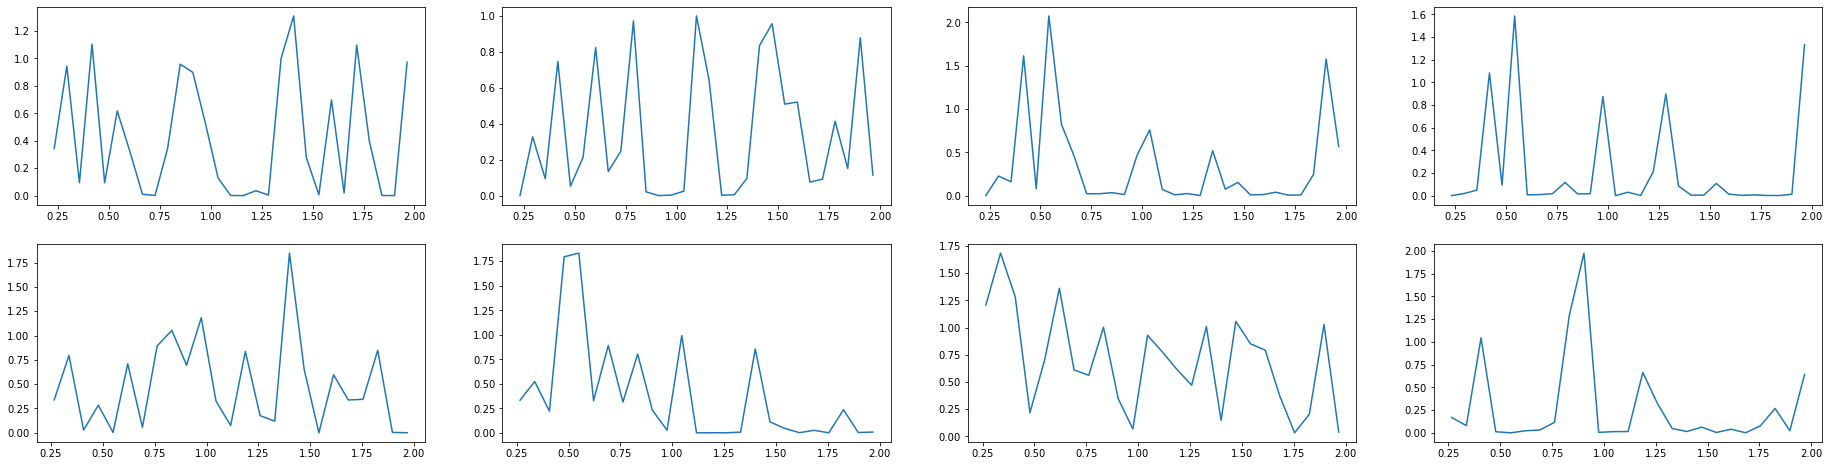

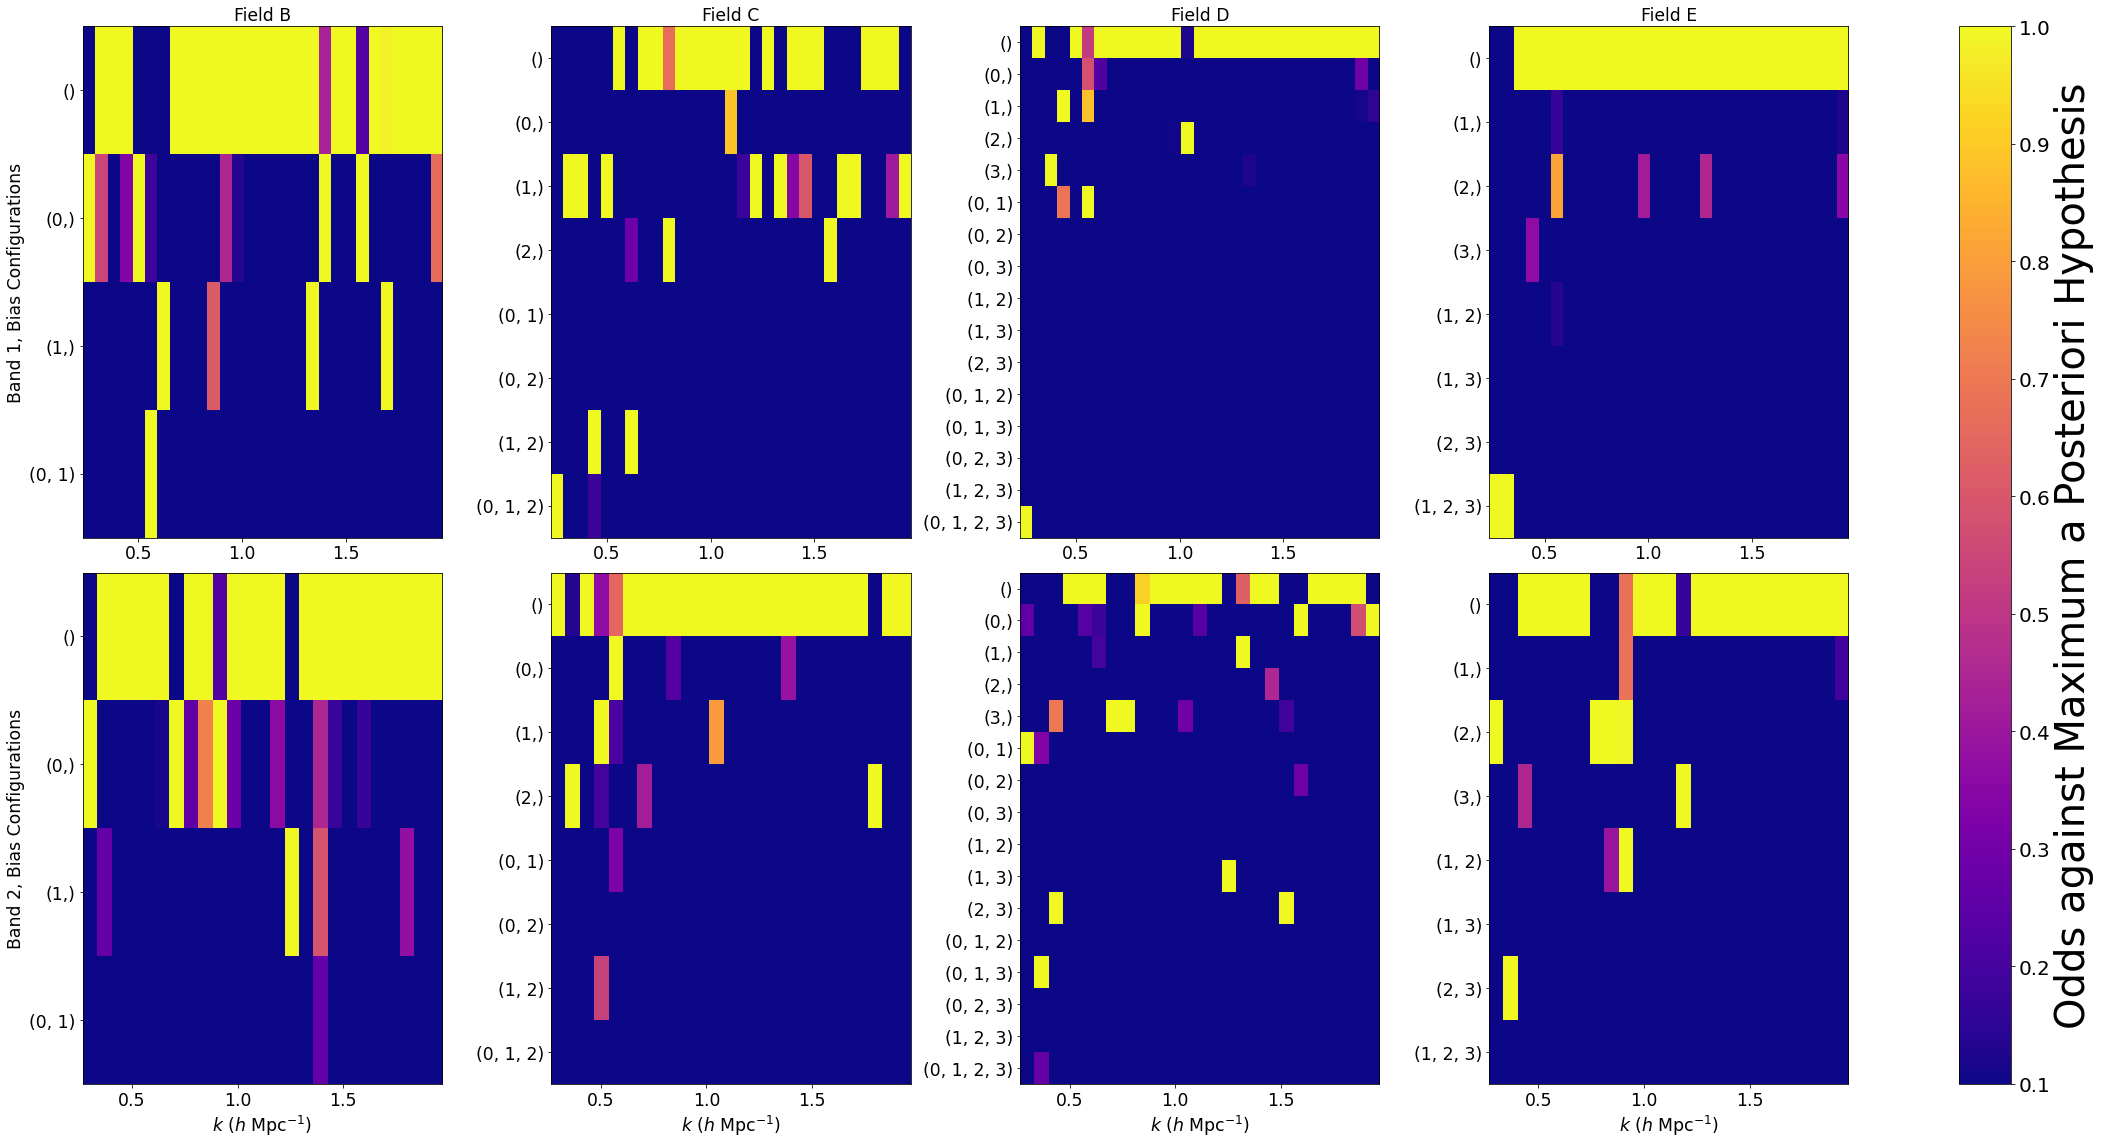

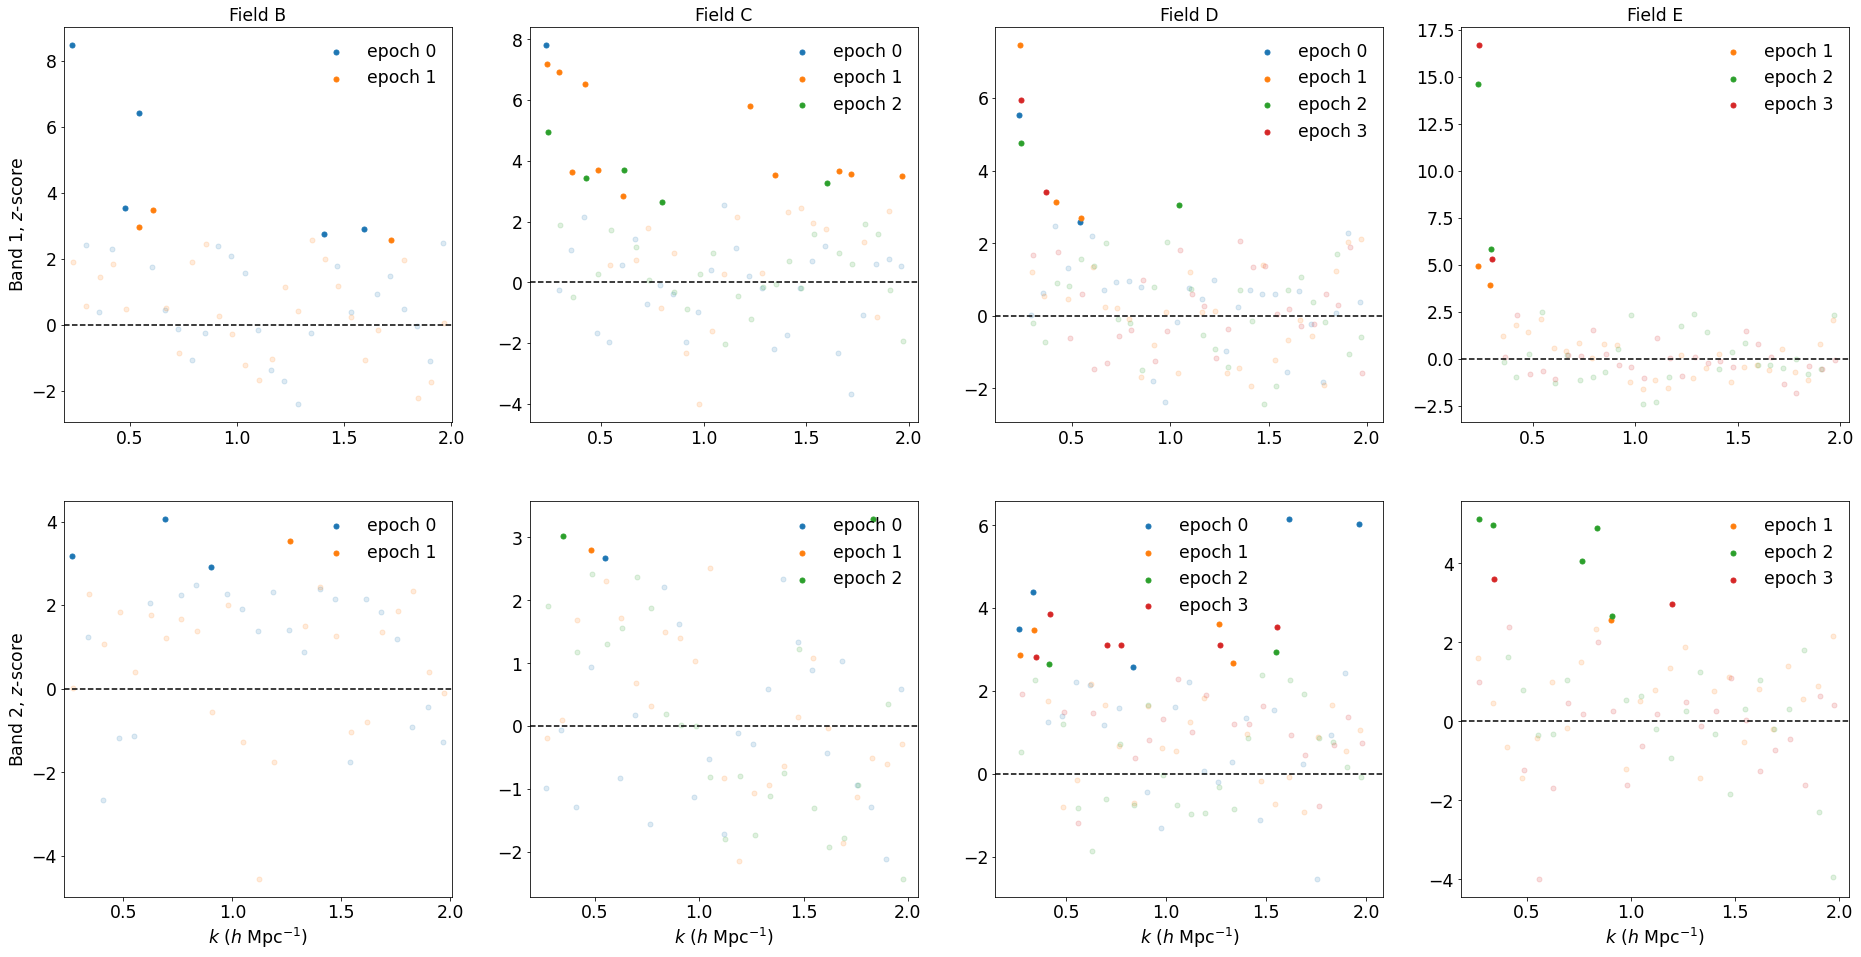

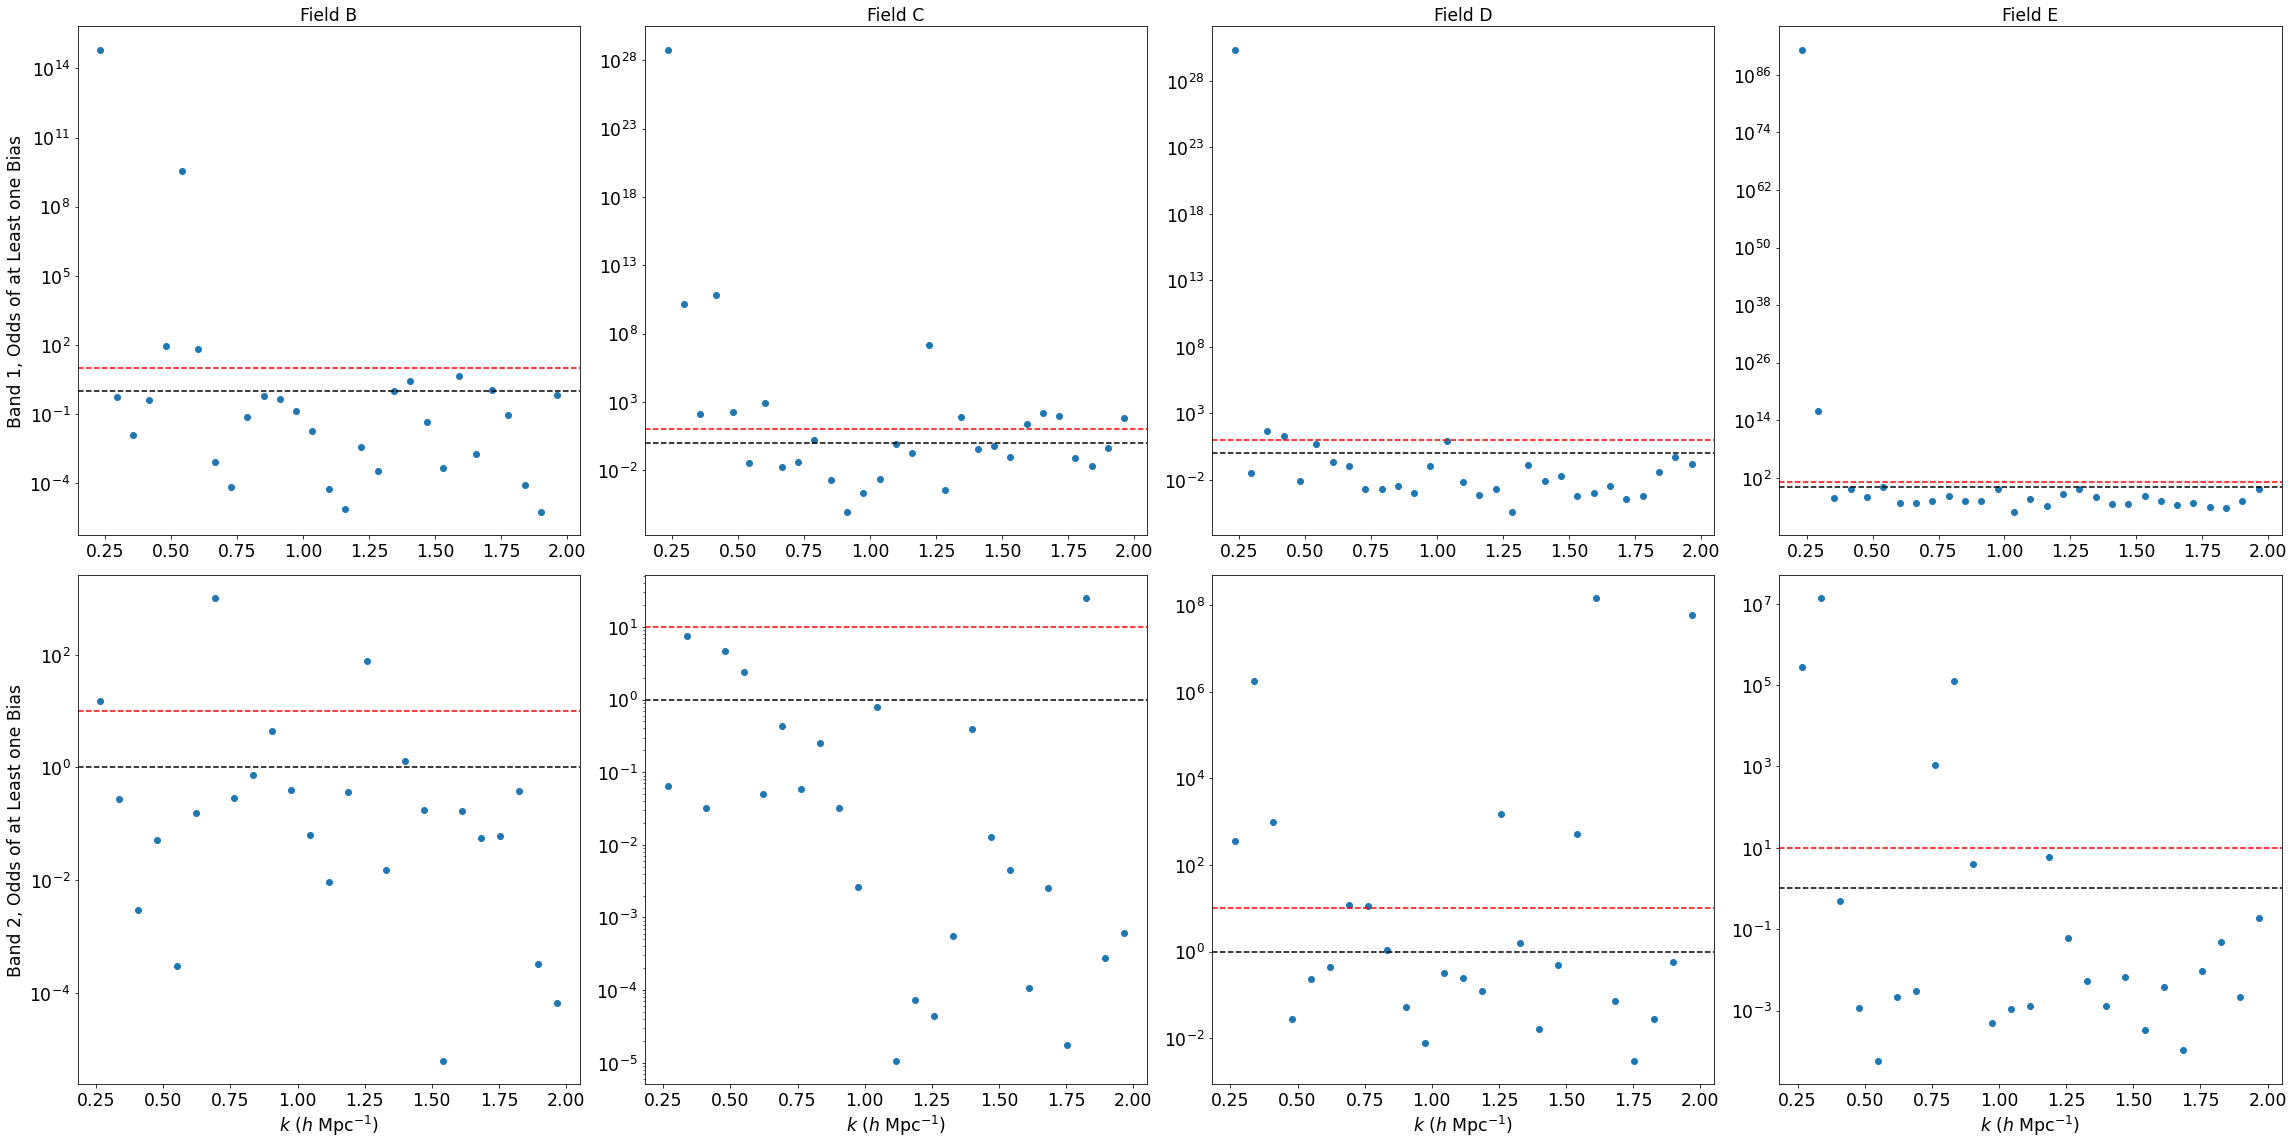

In [17]:
bias_jackknife_wrapper(fade_alpha=0.15, use_I=False, bias_prior_std=1, bppm=0, jk_mode="diag_only",
                       fields='BCDE', bias_prior_mean=6, print_stats=True)

In [8]:
for comp in ['real', 'imag']:
    for bpm_mag in [1, 6, 10]:
        for bpm_sign in [1, -1]:            
            bias_jackknife_wrapper(fade_alpha=0.15, use_I=False, bias_prior_std=1, bppm=0,
                                   jk_mode="diag_only", fields='BCDE', bias_prior_mean=bpm_mag * bpm_sign,
                                   comp=comp, close=True)


In [9]:
for comp in ['real', 'imag']:
    for plot_z in [True, False]:
        bias_jackknife_wrapper(fade_alpha=0.15, use_I=False, bias_prior_std=1e6, bppm=0, mult=False,
                               plot_z=plot_z, jk_mode="diag_only", fields='BCDE', bias_prior_mean=1e7,
                               comp=comp, close=True)

Average number of competing hypotheses: 4.0
Number of modes with strong evidence for bias: 0
Number of modes with moderate evidence for bias: 29
Average number of competing hypotheses: 8.0
Number of modes with strong evidence for bias: 3
Number of modes with moderate evidence for bias: 26
Average number of competing hypotheses: 16.0
Number of modes with strong evidence for bias: 29
Number of modes with moderate evidence for bias: 0
Average number of competing hypotheses: 8.0
Number of modes with strong evidence for bias: 1
Number of modes with moderate evidence for bias: 28
Average number of competing hypotheses: 4.0
Number of modes with strong evidence for bias: 0
Number of modes with moderate evidence for bias: 25
Average number of competing hypotheses: 8.0
Number of modes with strong evidence for bias: 8
Number of modes with moderate evidence for bias: 17
Average number of competing hypotheses: 16.0
Number of modes with strong evidence for bias: 25
Number of modes with moderate evid

KeyboardInterrupt: 

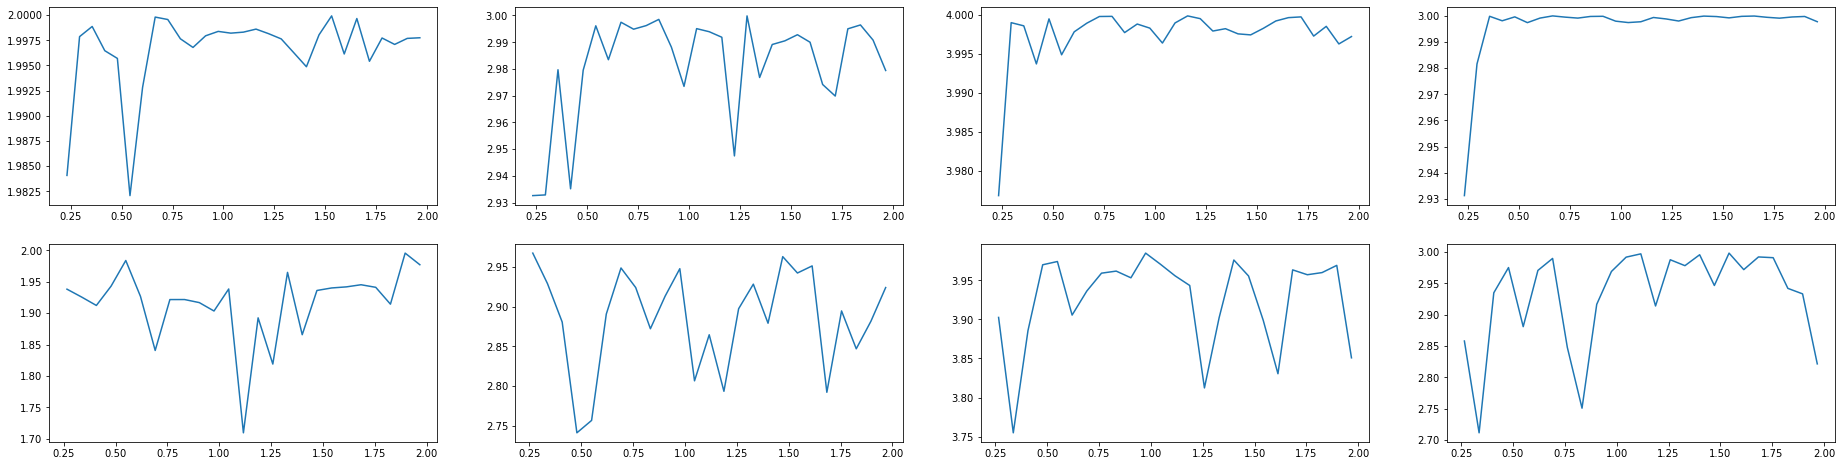

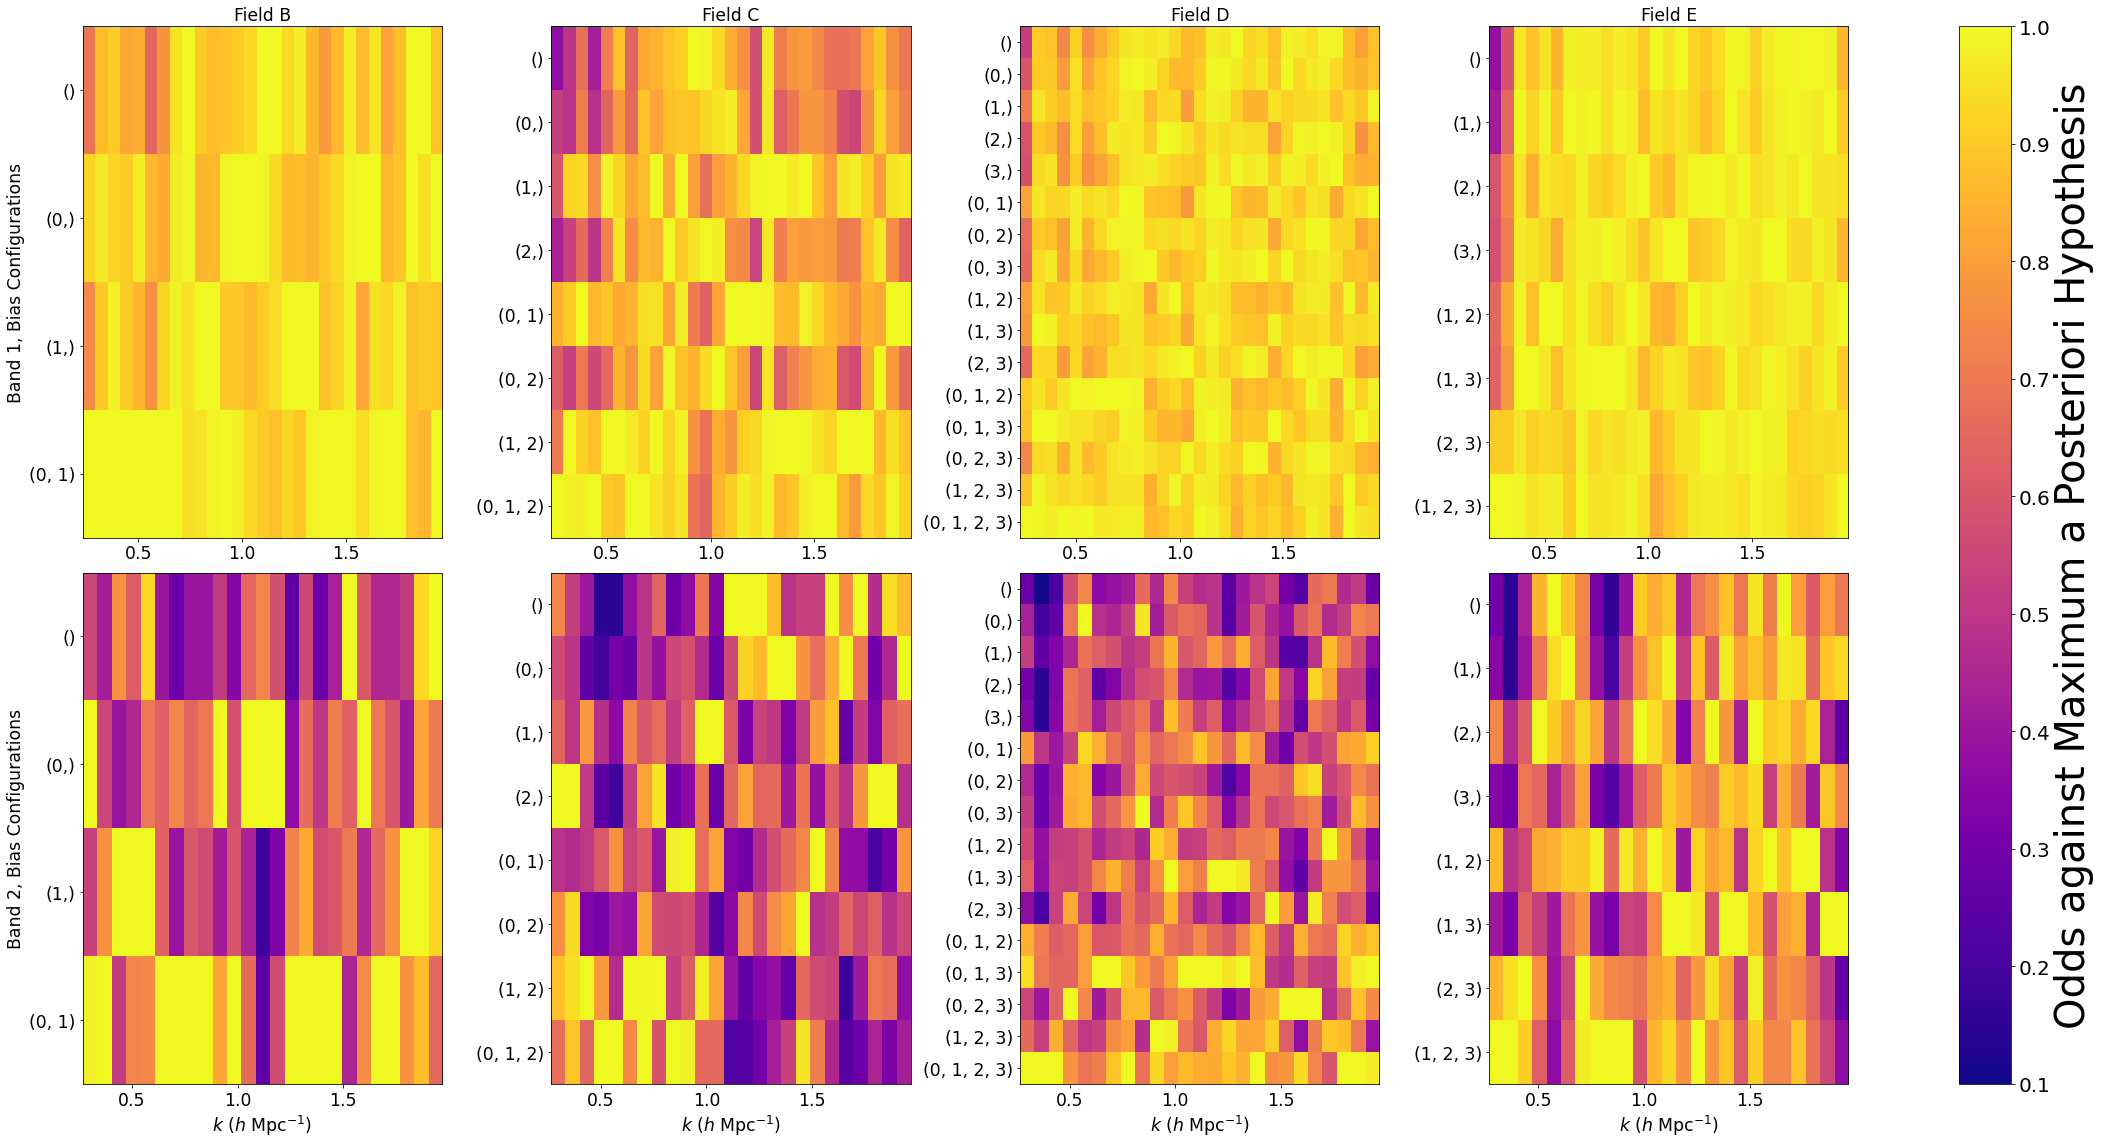

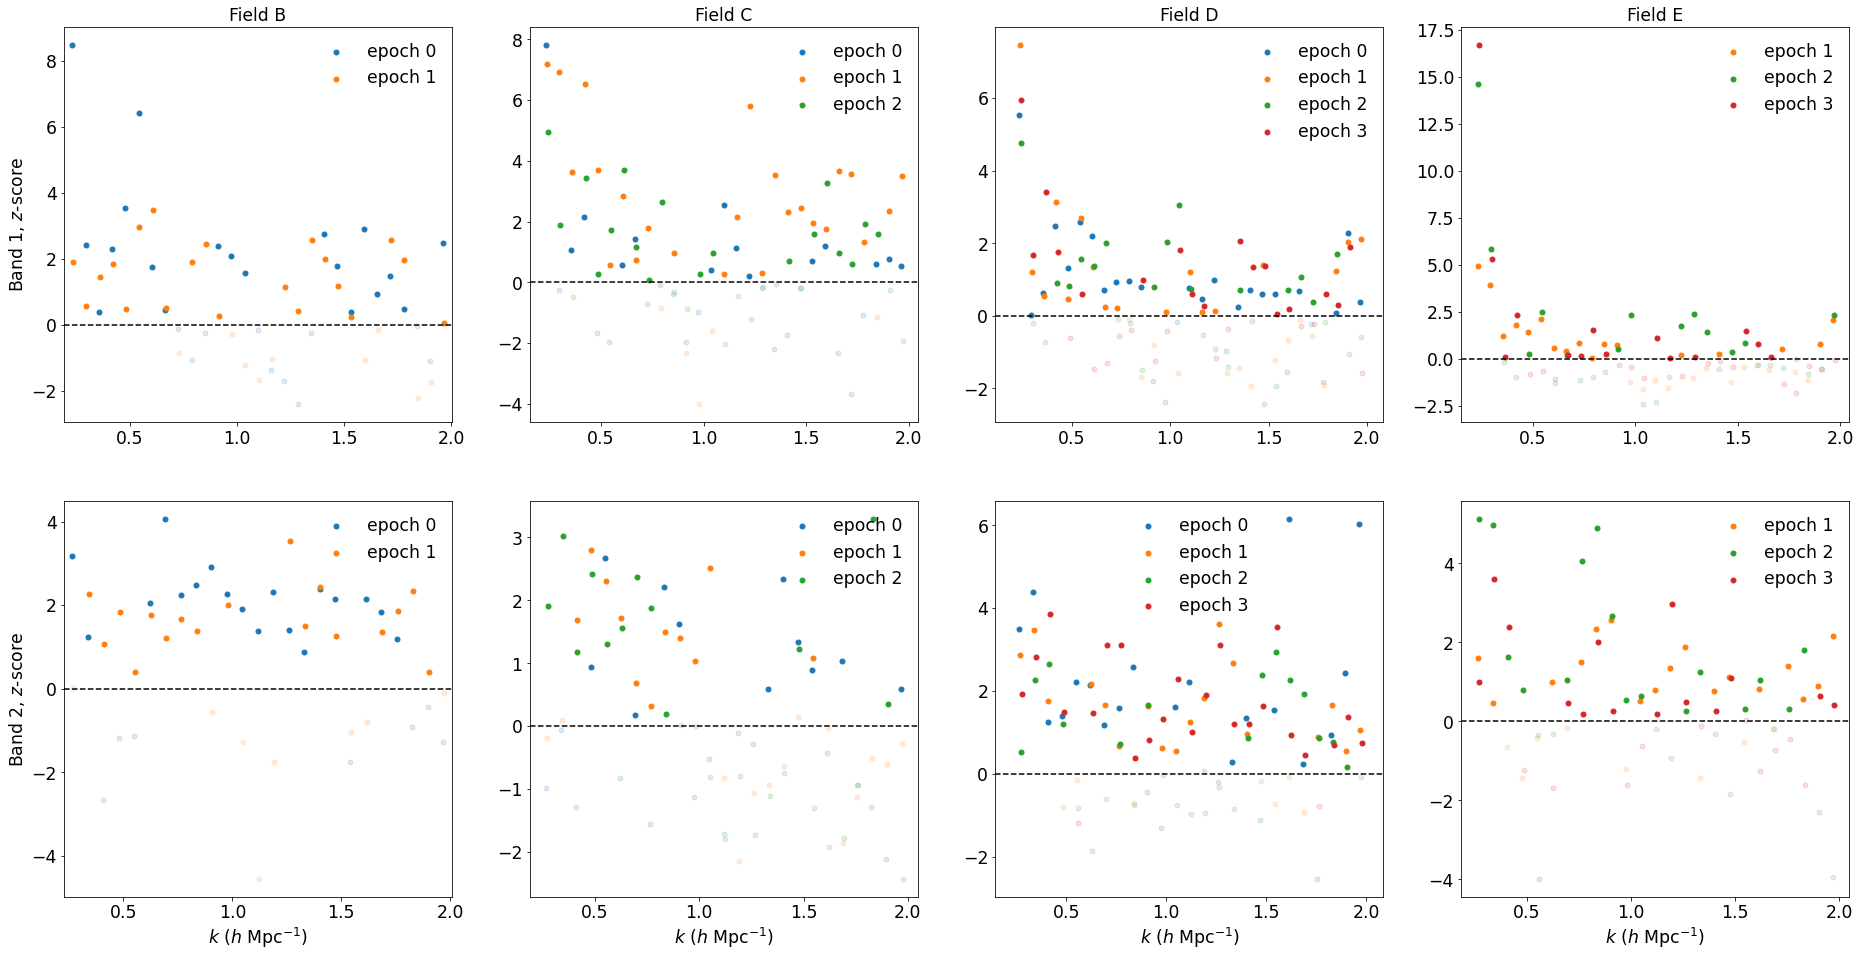

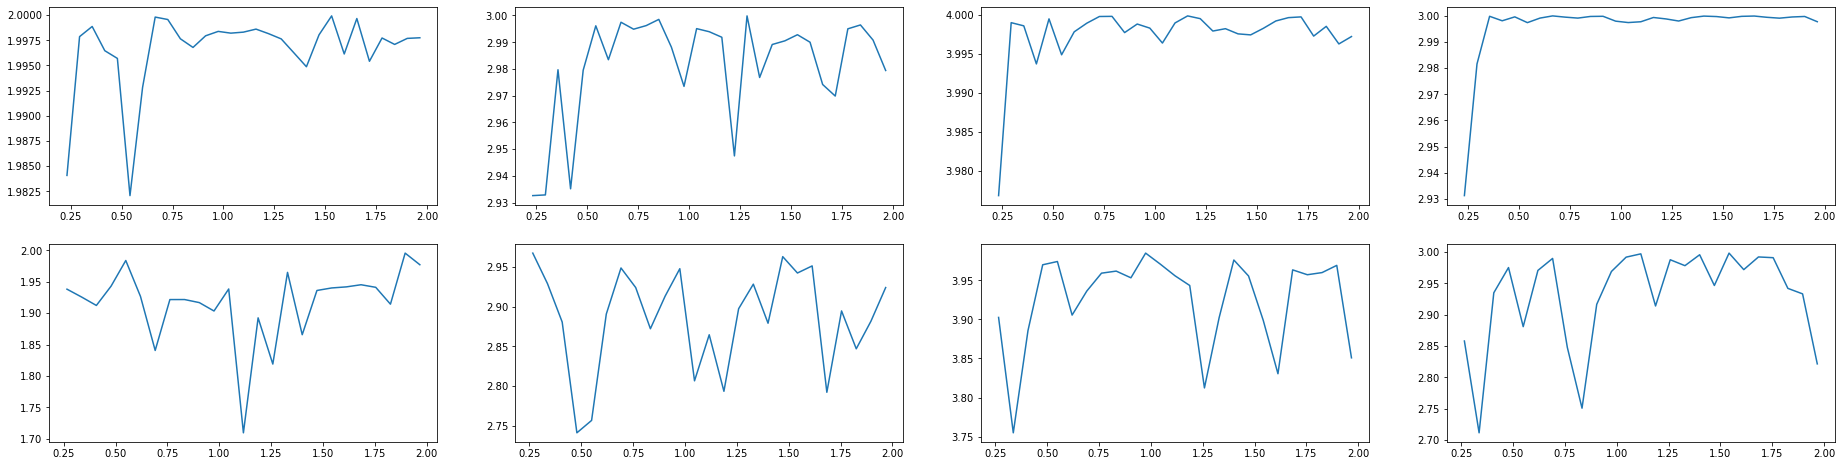

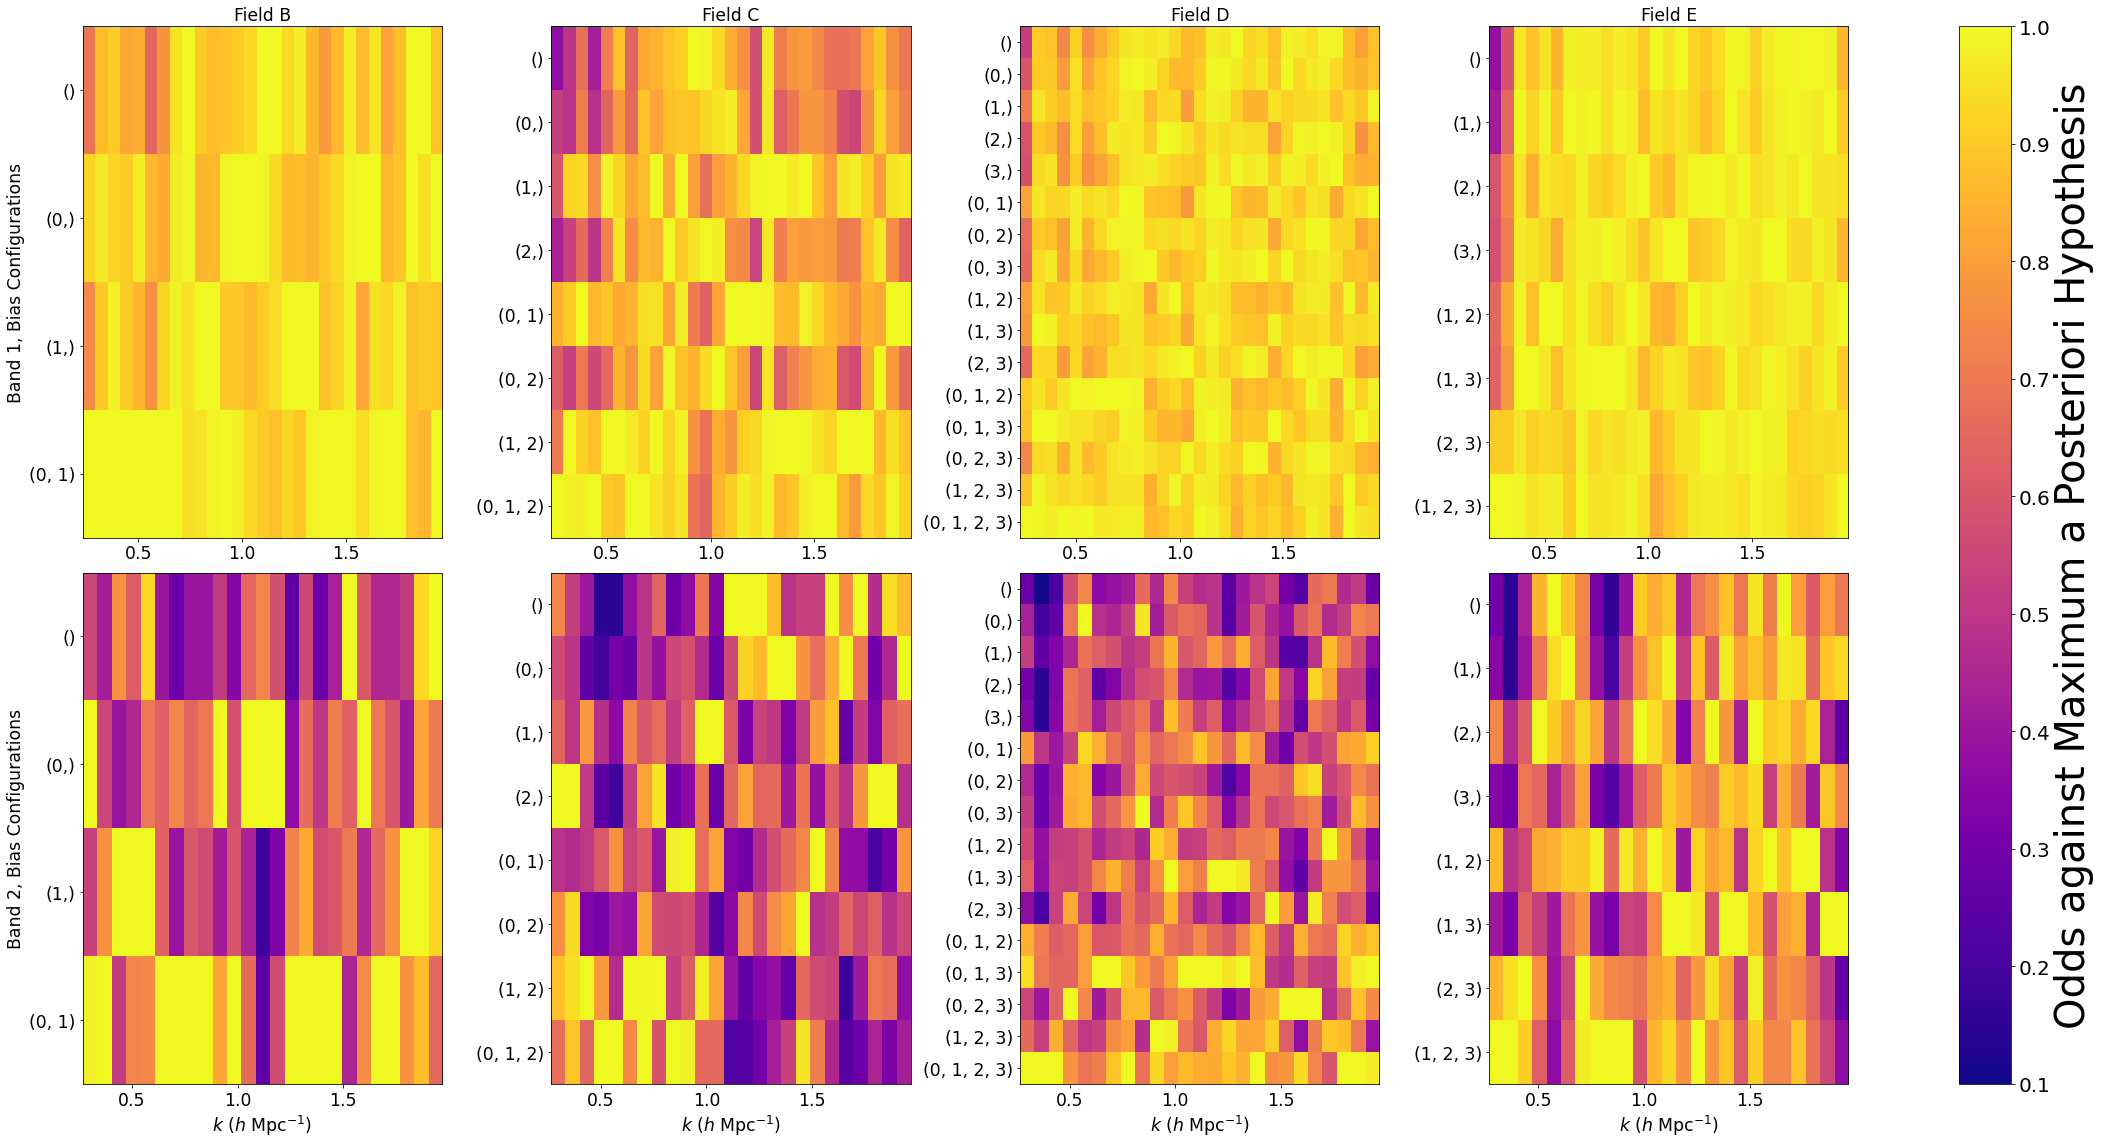

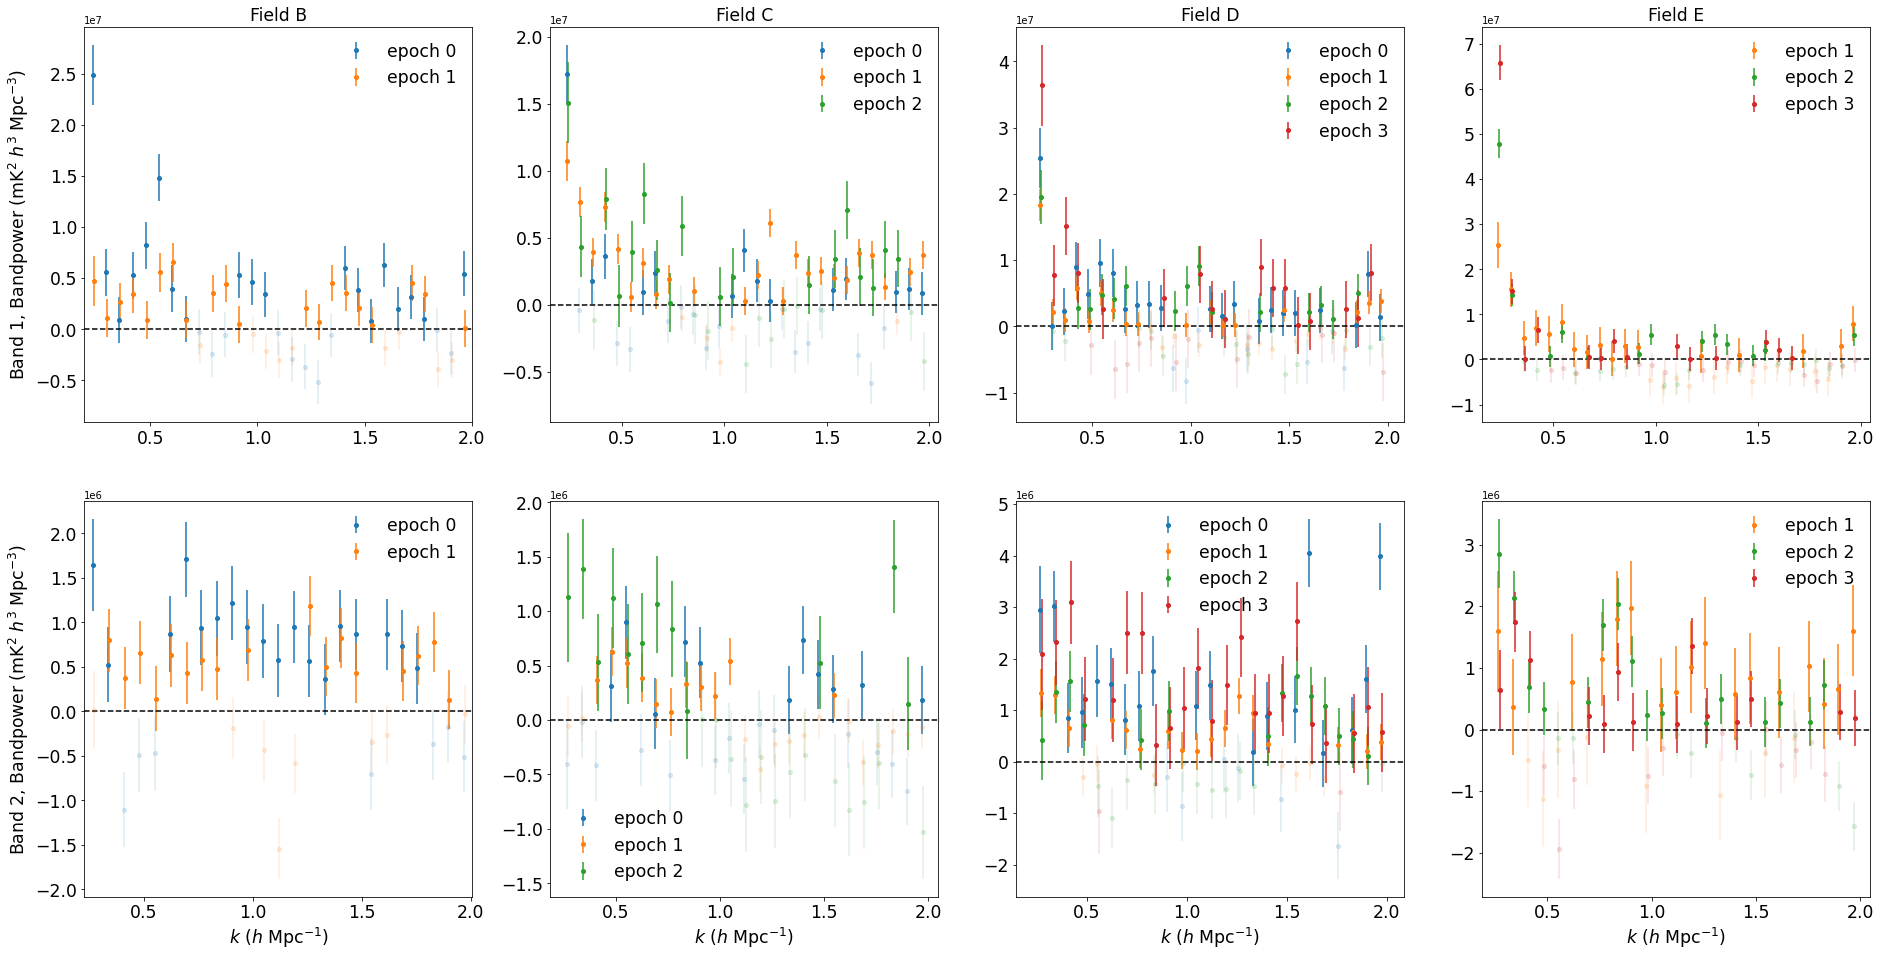

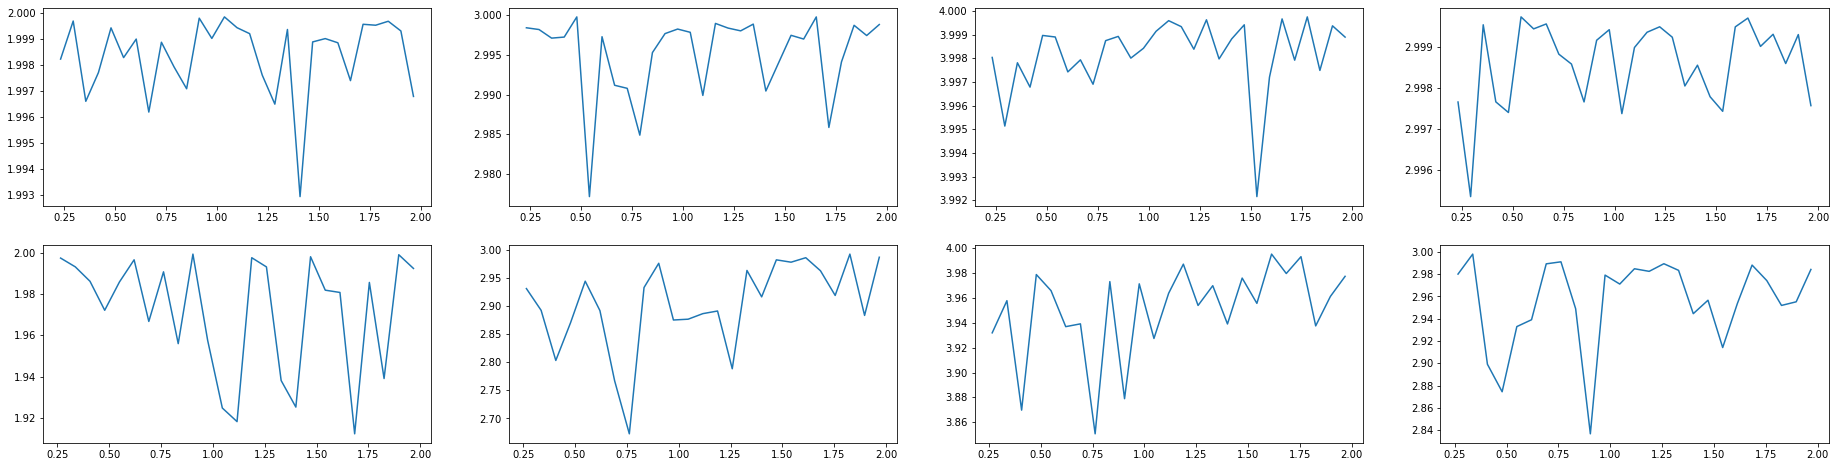

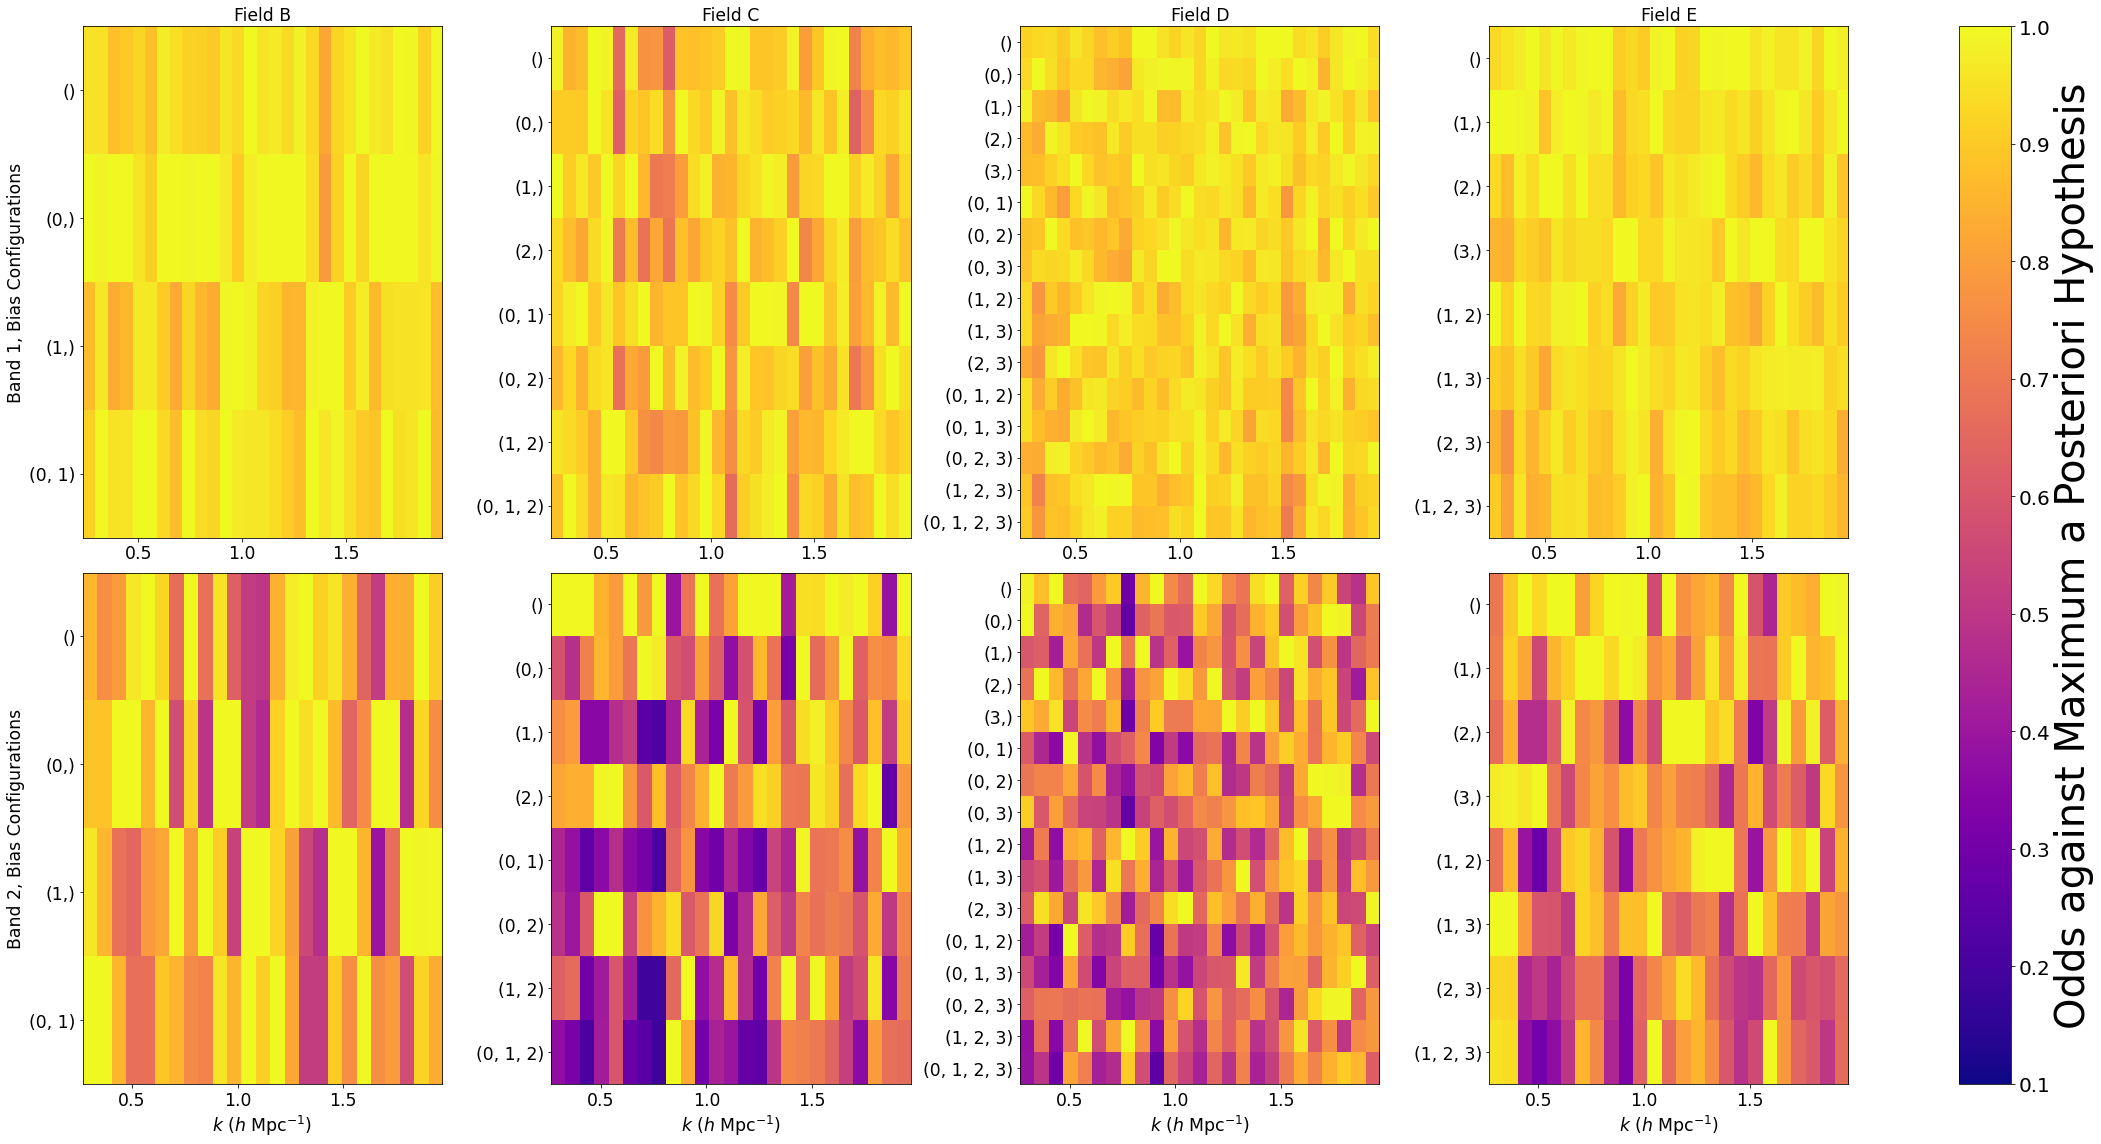

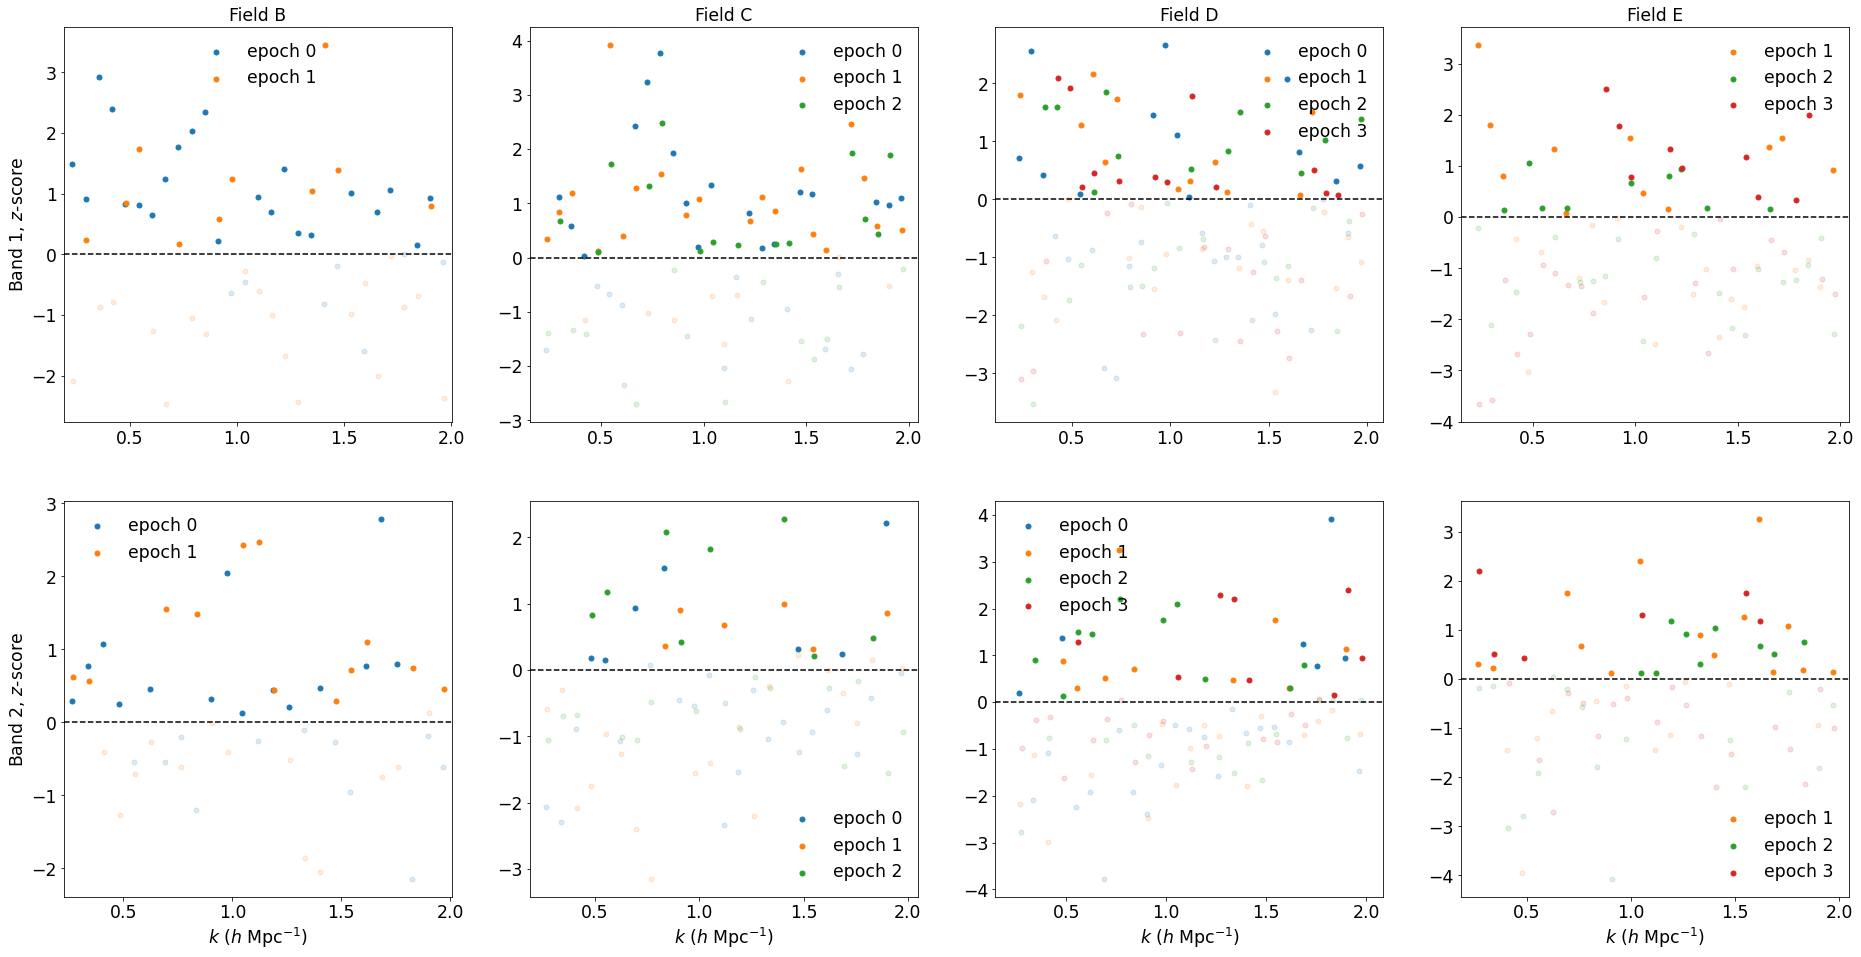

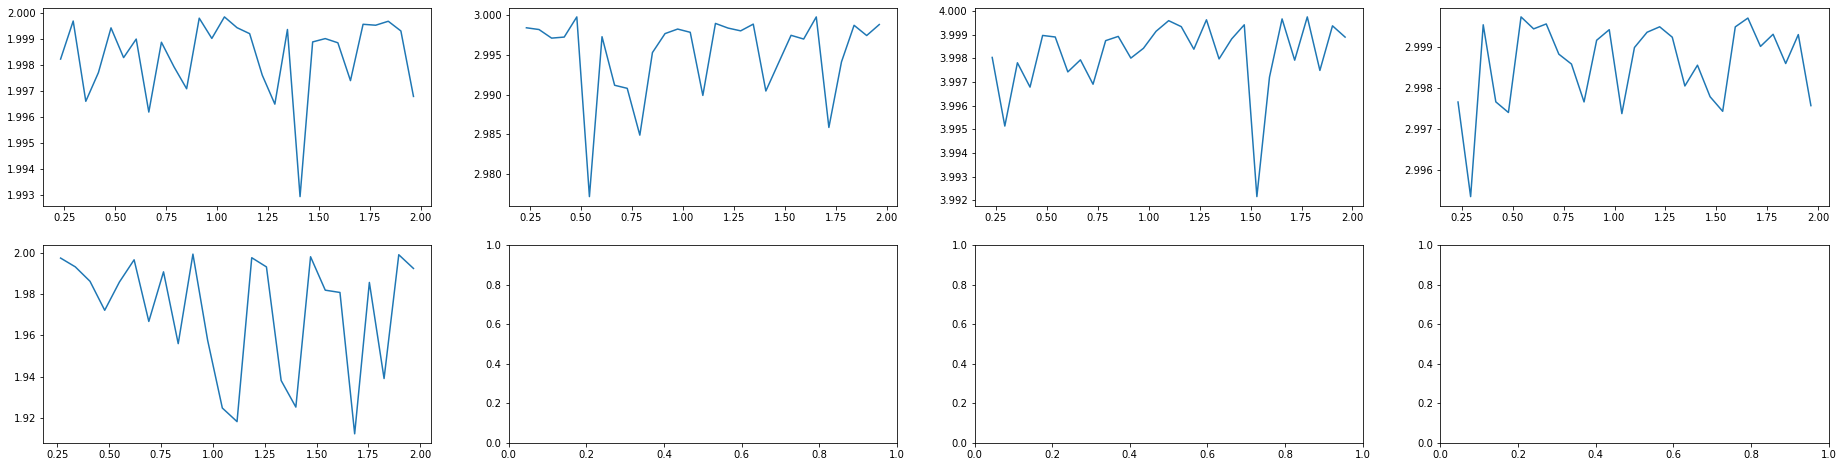

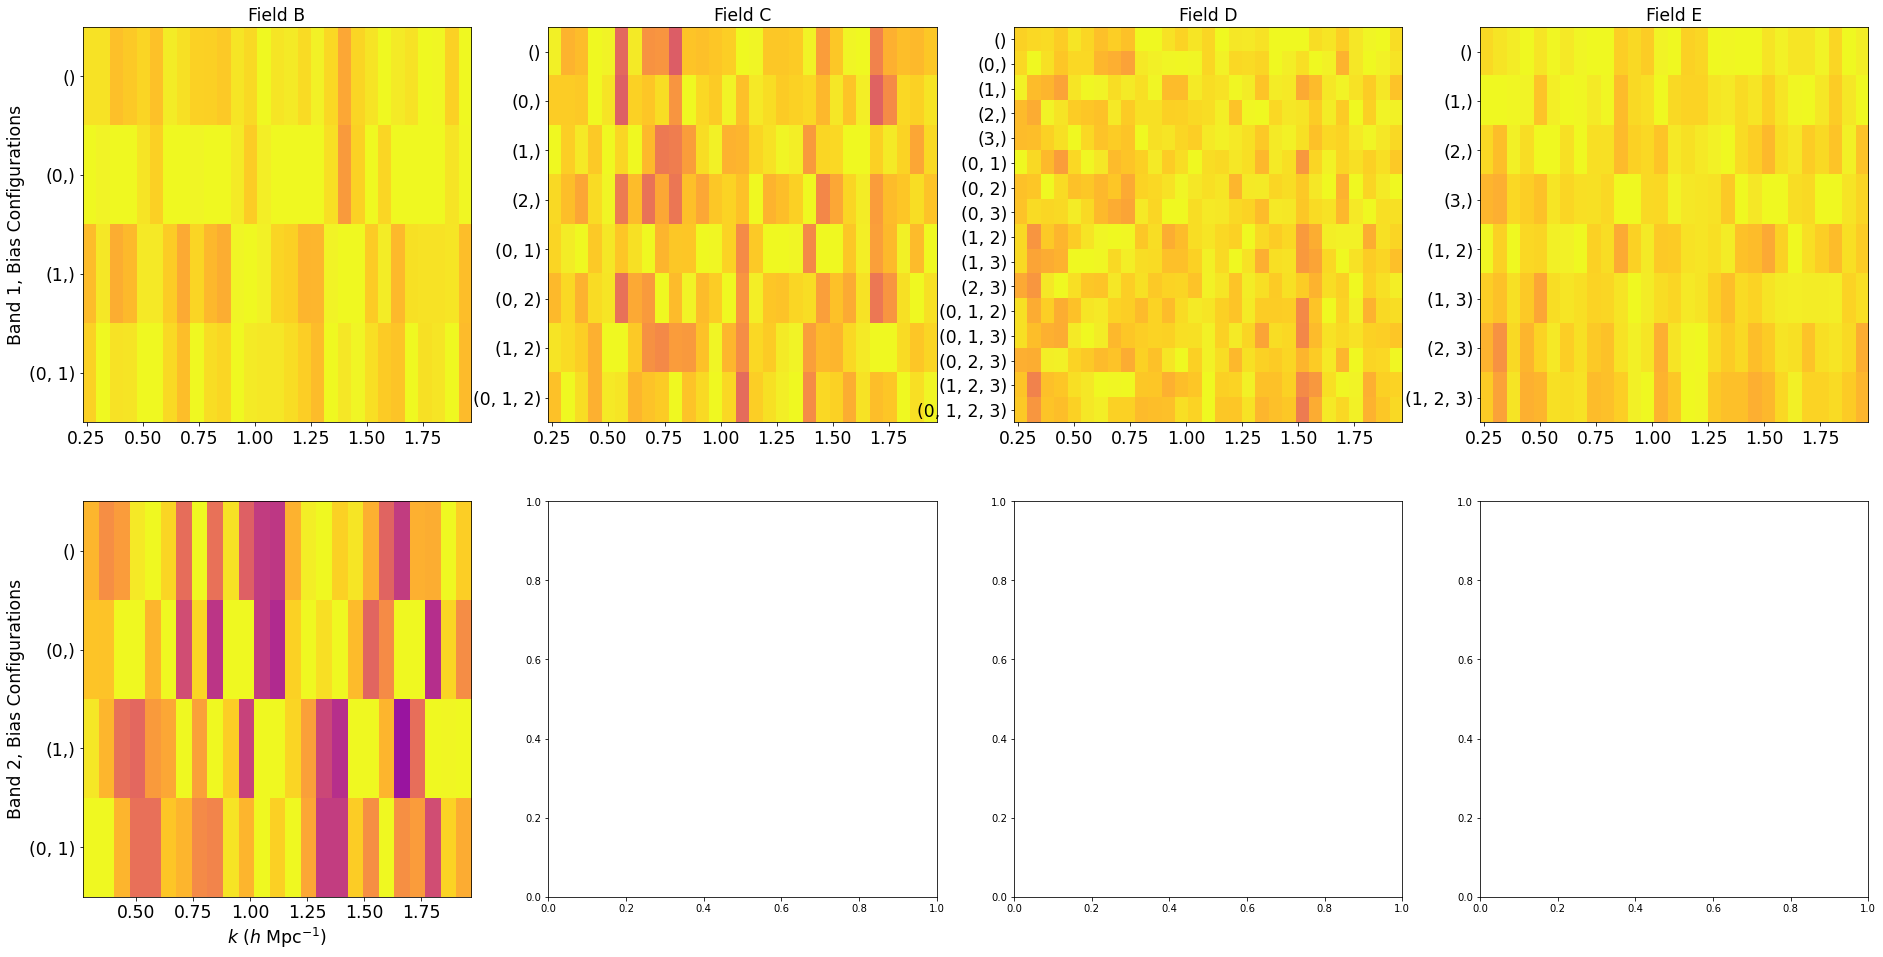

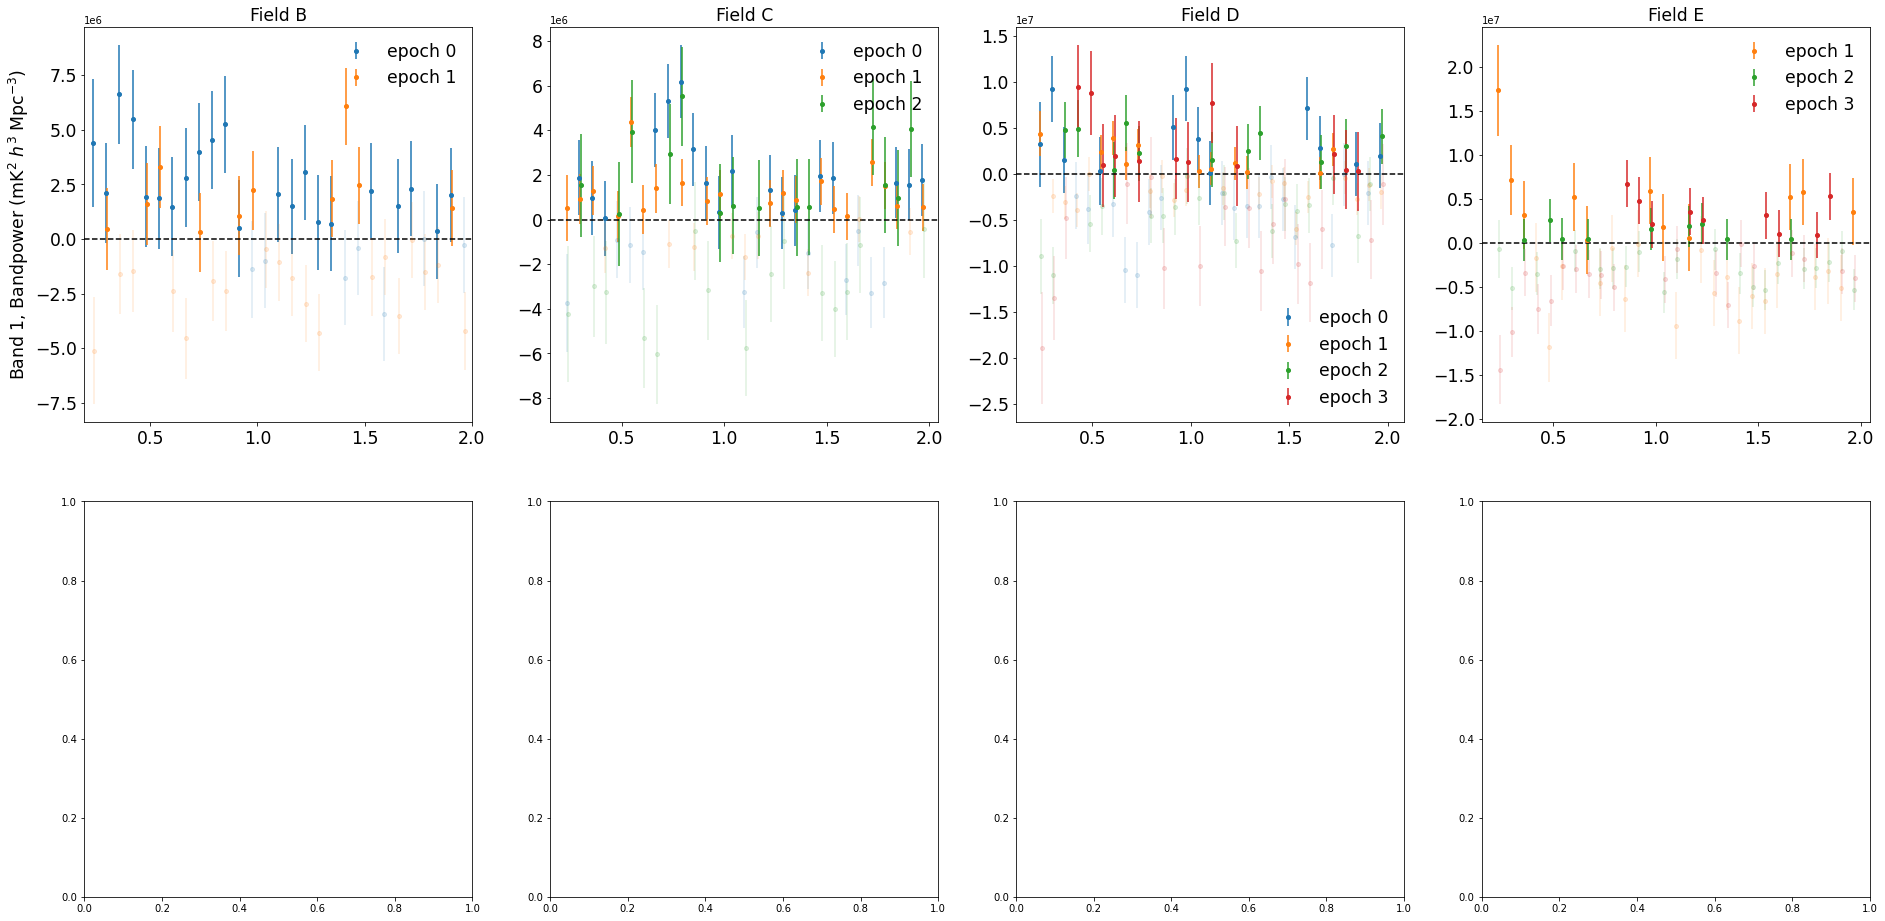

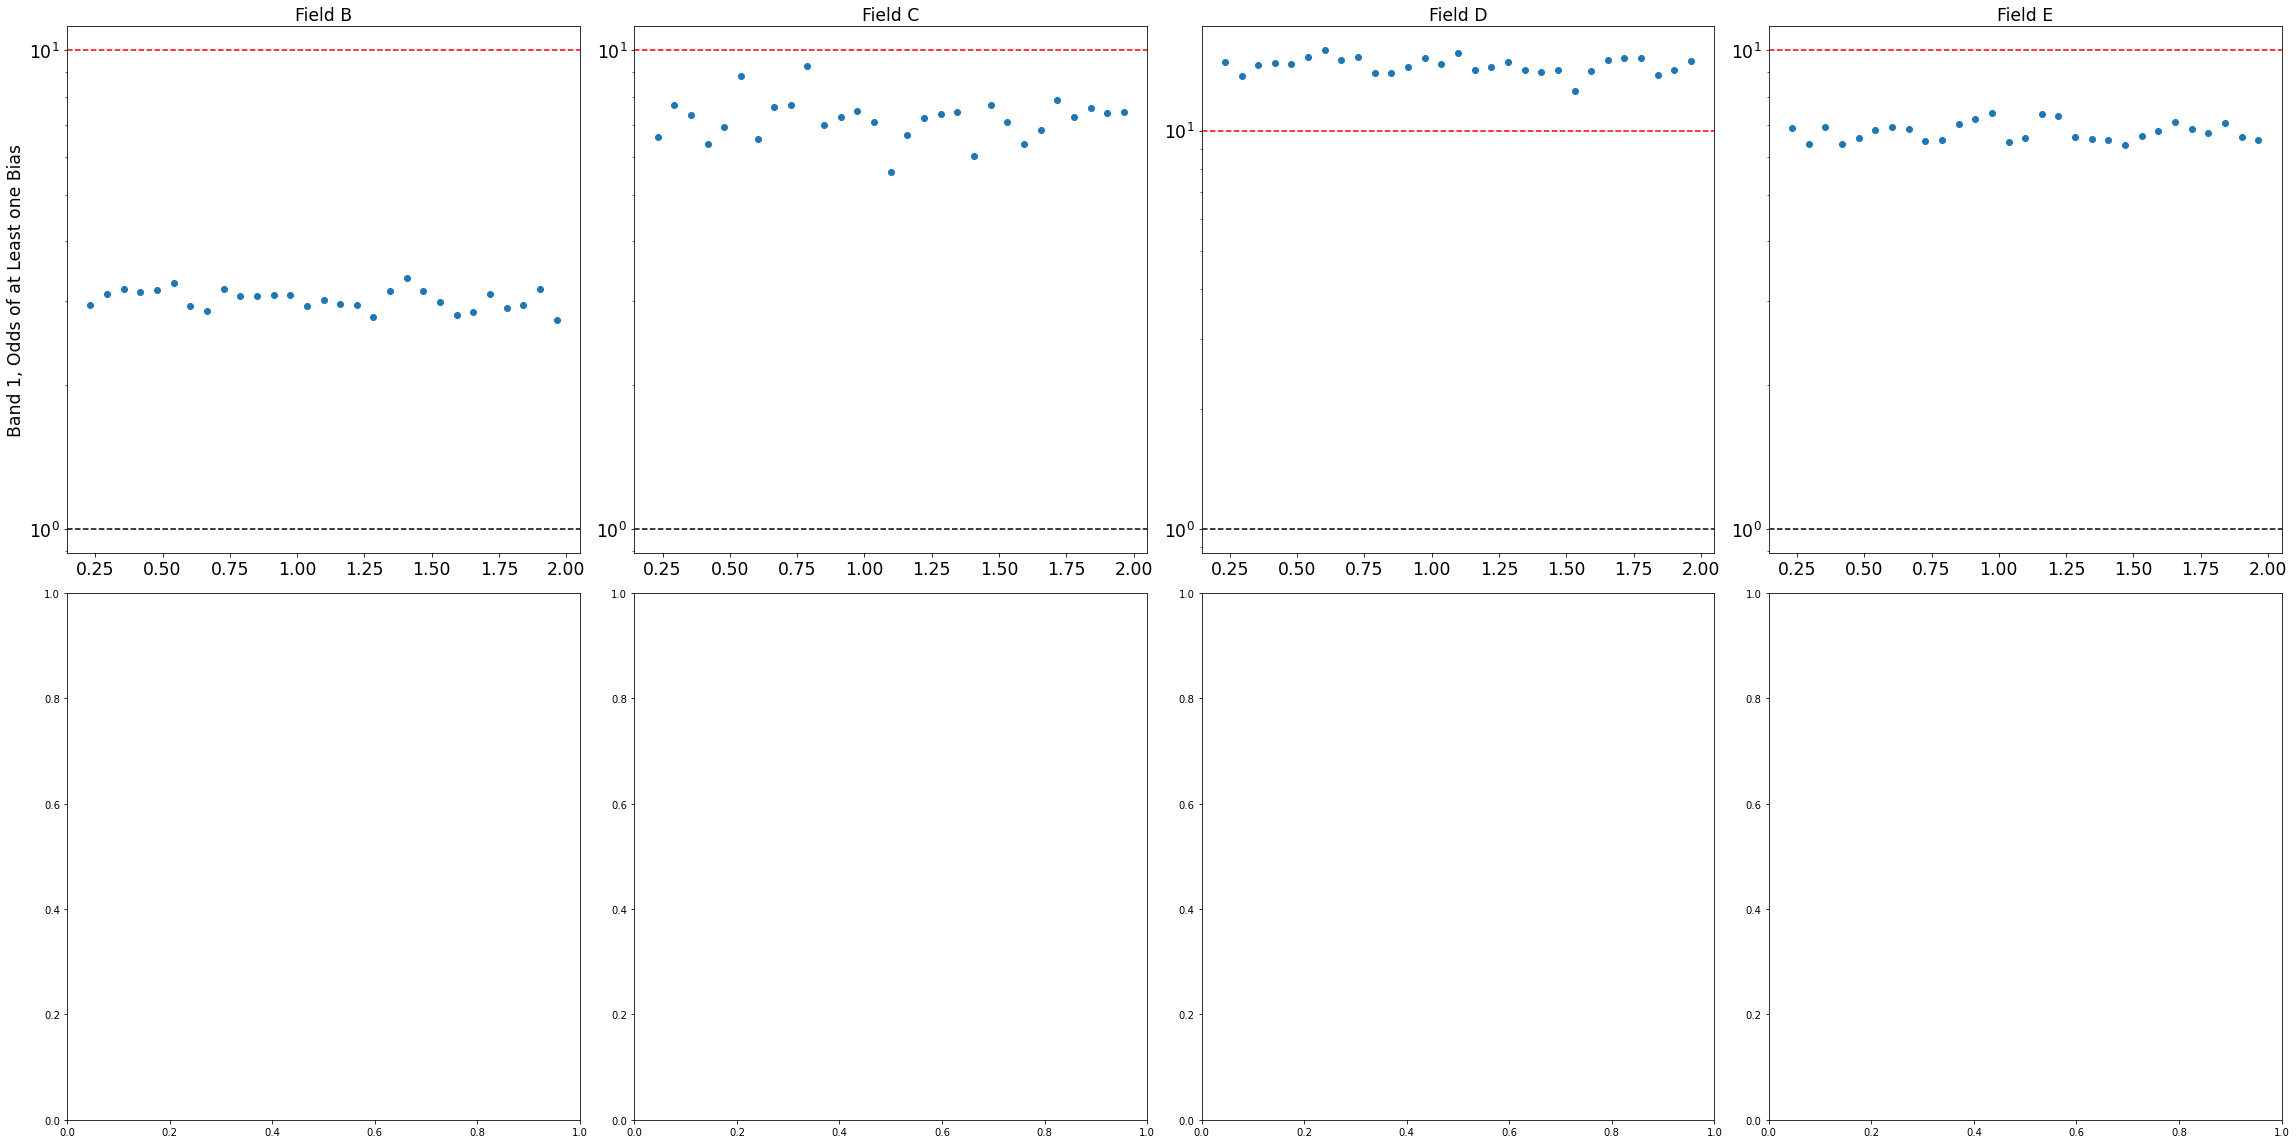

In [18]:
for comp in ['real', 'imag']:
    for plot_z in [True, False]:
        bias_jackknife_wrapper(fade_alpha=0.15, use_I=False, bias_prior_std=1e4, bppm=0, mult=False,
                               plot_z=plot_z, jk_mode="diag_only", fields='BCDE', bias_prior_mean=1e5,
                               comp=comp, print_stats=print_stats)
        plt.close()

In [11]:
for comp in ['real', 'imag']:
    for plot_z in [True, False]:
        bias_jackknife_wrapper(fade_alpha=0.15, use_I=False, bias_prior_std=1e5, bppm=0, mult=False,
                               plot_z=plot_z, jk_mode="diag_only", fields='BCDE', bias_prior_mean=1e6,
                               comp=comp, close=True)


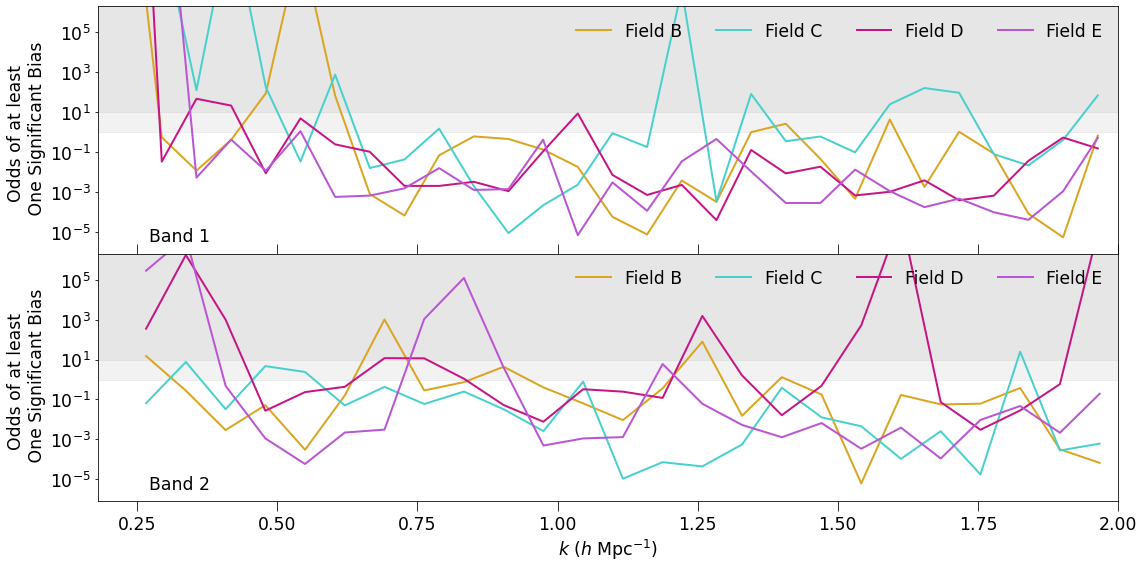

In [119]:
#lst_colors = ['gold', 'cyan', 'deeppink', 'mediumorchid']
lst_colors = ['goldenrod', 'mediumturquoise', 'mediumvioletred', 'mediumorchid']

def two_jk_wrapper(comp="real", bppm=10, stagger=0.004, use_I=False, figsize=(32, 8), alpha=0.5, lw=1.8,
                   bias_prior_std=1, jk_mode="diag_only", fields='BCDE', bias_prior_mean=6, dashz=-200,
                   plot_z=True, mult=True, close=False, print_stats=False, line=False, markersize=15, xwid=2,
                   shade_alpha=0.2, dash=False, shade=True):
    
    fig, ax = plt.subplots(figsize=figsize, nrows=2, ncols=1)
    for plot_ind, band in enumerate('12'):
        for field_ind, field in enumerate('BCDE'):
            epochs = epoch_dict[(band, field)]
            bp_meas_k, stds_k, ks = get_uvp_goodies(int(band), field, 'pk', epochs=epochs, comp=comp)
            odds_list_k, conc_list_k = get_odds_list_k(ks, stds_k, bp_meas_k, epochs, bppm=bppm, use_I=use_I,
                                                       bias_prior_std=bias_prior_std, jk_mode=jk_mode,
                                                       bias_prior_mean=bias_prior_mean, mult=mult)

            post_list_k = np.array([odds / np.sum(odds) for odds in odds_list_k])

            epoch_combos = get_epoch_combos(epochs)
            if (band == '1' and field == 'D') or (band == '2' and field == 'C'):
                marker = 'x'
                markeredgewidth=2
            else:
                marker = '.'
                markeredgewidth=None
            
            odds_plot(ax[plot_ind], ks, post_list_k, 1, 1, marker=marker,
                      print_stats=print_stats, color=lst_colors[field_ind], label=f"Field {field}",
                      line=line, markersize=markersize, alpha=alpha, lw=lw, dashz=dashz,
                      markeredgewidth=markeredgewidth, dash=dash)

        ax[plot_ind].text(x=0.05, y=0.05, s = f"Band {band}", fontsize="xx-large", transform=ax[plot_ind].transAxes)
        ax[plot_ind].legend(fontsize="xx-large", frameon=False, ncol=4)
        ax[plot_ind].set_ylim([8e-7, 2e6])
        ax[plot_ind].set_ylabel(f"Odds of at least \n One Significant Bias", fontsize="xx-large")
        ax[plot_ind].set_xlim([0.18, 2.00])
        if shade:
            ax[plot_ind].axhspan(ymin=1e0, ymax=1e10, alpha=shade_alpha, color="gray")
            ax[plot_ind].axhspan(ymin=1e1, ymax=1e10, alpha=shade_alpha, color="gray")
    ax[0].set_xticklabels([])
    ax[0].tick_params(axis='x', direction='in', length=10)
    ax[1].tick_params(axis='x', direction='out', length=10)
    ax[0].set_xlabel(None)
    fig.tight_layout(h_pad=0)
    fig.savefig("jackknife_two_panel.pdf")

two_jk_wrapper(use_I=False, bias_prior_std=1, bppm=0, jk_mode="diag_only", dashz=-200, shade_alpha=0.1,
               bias_prior_mean=6, figsize=(16, 8), line=True, alpha=1, lw=2, markersize=0)

# Scratch Paper

For N diagonals that are on, find the adjacency matrices for complete graphs of each partition

Do you just shift the partitions diagonally?

There's something very important about **conjugate partitions**

On/off, corr/uncorr

"Write down adjacency matrices for all possible cluster graphs of N points"

In [ ]:
print(list(powerset(range(4))))

In [ ]:
from scipy.special import comb
print(comb(2*2, 2))

# Some code I would like preserved



In [ ]:
from more_itertools import set_partitions

In [ ]:
parts = set_partitions(np.arange(4))
for part in parts:
    print(part)

In [ ]:
from itertools import combinations
list(combinations([0], 2))

In [ ]:
from scipy.special import comb
def get_num_hyp(N):
        """
        Fun fact: these are called bell numbers. For N bandpowers, we actually
        want the N+1th bell number, which is the total number of ways of
        partitioning a set with N+1 elements.
        """
        M = N + 1
        B = np.zeros(M + 1)
        B[0] = 1  # NEED THE SEED
        for n in range(M):
            for k in range(n + 1):
                B[n + 1] += comb(n, k, exact=True) * B[k]


        return(B)

In [ ]:
print(get_num_hyp(5))

In [ ]:
M = 0.1 * np.eye(2) + np.ones([2, 2])
inv = np.linalg.inv(M)
print(inv)
print(np.linalg.eig(inv))
x = np.full(2, 1 / np.sqrt(2))
print(x.T@inv@x)

In [ ]:
M = 0.1 * np.eye(2) + np.array([[1, 0], [0, 1]])
inv = np.linalg.inv(M)
print(inv)
print(np.linalg.eig(inv))
x = np.full(2, 1 / np.sqrt(2))
print(x.T@inv@x)

In [ ]:
np.random.multinomial(100, pvals=[0.33, 0.34, 0.33], size=1)

In [ ]:
np.arange(10).reshape((5, 2))

In [ ]:
N = 16

P = np.ones(N)
P[0] = 10
P = P / P.sum()
print(P)
-P@np.log(P) / np.log(N)

In [ ]:
np.ones(3) @ np.linalg.inv(np.eye(3) + 100 * np.ones([3, 3])) @ np.ones(3)

In [ ]:
np.ones(3) @ np.linalg.inv(np.eye(3) + 100 * np.eye(3)) @ np.ones(3)

In [ ]:
x= np.random.normal(size=2)
y = np.random.normal(loc=[5, 0], size=2)
sig_p = 10
mu_p = np.array([0, 0])
sig_post = np.sqrt(1 / (1 + 1/sig_p**2))

mu = sig_post**2 * (y + mu_p/sig_p**2)
print(mu)
print(y)
print(sig_post)

In [ ]:
print(sig_like)
print(1/ (1 + 1/1e4))

In [ ]:
np.linalg.inv([[1, 0.9], [0.9, 1]])

In [ ]:
plt.close()

In [ ]:
mean1 = np.zeros(4)
std1 = 1
mean2 = np.repeat(1, 4)
I = []
stds = np.logspace(-2, 2, num=100)
num_draw = int(1e4)
for std2 in stds:
    std_use = np.sqrt(std1**2 + std2**2)
    dat1 = np.random.multivariate_normal(mean=mean1, cov=std1 * np.eye(4), size=num_draw)
    dat2 = np.random.multivariate_normal(mean=mean2, cov=std_use * np.eye(4), size=num_draw)
    trial = np.random.multinomial(1, [0.5, 0.5], size=num_draw).argmax(axis=1)
    dat = np.choose(trial, [dat1.T, dat2.T]).T
    

    like1 = multivariate_normal(mean=mean1, cov=std1).pdf(dat)
    like2 = multivariate_normal(mean=mean2, cov=std_use).pdf(dat)

    
    P = 0.5 * (like1 + like2)
    Hd = -np.log2(P).mean()
    
    Hcond = 0.5 * (multivariate_normal(mean=mean1, cov=std1 * np.eye(4)).entropy() + multivariate_normal(mean=mean2, cov=std_use*np.eye(4)).entropy()) / np.log(2)
    
    Inow = (Hd - Hcond) #/ np.log(2)
    I.append(Inow)

plt.plot(stds, I)
plt.xscale("log")

In [ ]:
from scipy.spatial.distance import jensenshannon as js

x = np.linspace(-10, 10, num=100)
y1 = norm.pdf(x)
scales = np.logspace(-2, 2, base=10)
JS = []
for scale in scales:
    y2 = norm(loc=10, scale=scale).pdf(x)
    JS.append(js(y1, y2, base=2))

plt.plot(scales, np.array(JS)**2)
plt.xscale("log")



In [ ]:
from scipy.spatial.distance import jensenshannon as js

x = np.linspace(-10, 10, num=100)
X, Y, Z = np.meshgrid(x, x, x)
R = np.array([X.flatten(), Y.flatten(), Z.flatten()]).T
y1 = multivariate_normal(mean=np.zeros(3)).pdf(R)
scales = np.logspace(-2, 2, base=10)
JS = []
for scale in scales:
    y2 = multivariate_normal(mean=scale*np.ones(3), cov=6*np.eye(3)).pdf(R)
    HdA = 0.5 * multivariate_normal(mean=np.zeros(3)).entropy() + 0.5 * multivariate_normal(mean=scale*np.ones(3), cov=6*np.eye(3)).entropy()
    Hd = 
    JS.append(js(y1, y2, base=2))





In [ ]:
plt.plot(scales, np.array(JS)**2)
plt.xscale("log")

In [ ]:
num_pow = 4
num_draw = int(1e6)
bias = np.random.multivariate_normal(mean = np.zeros(num_pow), cov = 0.2 * np.eye(num_pow), size=num_draw)
mean = 0
bp = bandpower(num_pow=4, bias=bias, mean=mean, std=1)
jk = bias_jackknife(bp, bias_prior_mean=0, bias_prior_std=10, bp_prior_mean=0, bp_prior_std=0, mode="ternary",
                    hyp_prior=[0.5, 0.5, 0])
H = (-jk.post[:2] * np.log2(jk.post[:2])).sum(axis=0)

_, _, _ = plt.hist(H, bins=np.linspace(0, 1, num=100), histtype='step')
print(np.nanmean(H))

In [ ]:
_, _, _ = plt.hist(jk.post[1], bins=np.linspace(0, 1, num=100), histtype='step')

In [12]:
1 in (1,)

True